# Import statements

In [1]:
!pip install wfdb
!pip install spkit
!pip install neurokit2
!pip install tf_keras_vis
!pip install pydot
!pip install graphviz


[notice] A new release of pip is available: 24.1.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
  Using cached pydot-4.0.1-py3-none-any.whl.metadata (11 kB)
Using cached pydot-4.0.1-py3-none-any.whl (37 kB)

[notice] A new release of pip is available: 24.1.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
  Using cached graphviz-0.21-py3-none-any.whl.metadata (12 kB)
Using cached graphviz-0.21-py3-none-any.whl (47 kB)

[notice] A new release of pip is available: 24.1.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
#preprocess
import wfdb
import matplotlib.pyplot as plt
import spkit as sp
import neurokit2 as nk
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

# Model
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import json
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.utils import plot_model
import pydot
import graphviz

#saliency maps
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.scorecam import Scorecam
import scipy.ndimage
from tf_keras_vis.utils.model_modifiers import GuidedBackpropagation

# Activation Maximization
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.regularizers import Norm, Regularizer
from tf_keras_vis.activation_maximization.input_modifiers import Jitter

/opt/conda/lib/python3.11/site-packages/neurokit2/signal/signal_findpeaks.py:3: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
/opt/conda/lib/python3.11/site-packages/tf_keras_vis/gradcam.py:6: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
/opt/conda/lib/python3.11/site-packages/tf_keras_vis/gradcam_plus_plus.py:6: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
/opt/conda/lib/python3.11/site-packages/tf_keras_vis/scorecam.py:6: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
/opt/conda/lib/python3.11/site-packages/tf_keras_vis/utils/regularizers.py:8: DeprecationWarning: `tf_keras_vis.utils.reg

# Preprocess

## Load data

Loads the whole dataset from physionet and extracts the signals, P and R peak annotations and the sampling frequency.

In [3]:
# get the data 
record_names = wfdb.get_record_list('but-pdb')
database = 'but-pdb'

#store data from different records
signals = []
p_anns = []
r_anns = []
samp_freq = []

for i, rec in enumerate(record_names):
    #load record
    record = wfdb.rdrecord(f"{int(rec):02}", pn_dir = database)
    if record.fs != 360:
        continue
    if i == 35:
        break
    

    #load signal and annotations
    sig = record.p_signal[:,0]
    p_ann = wfdb.rdann(f"{int(rec):02}", 'pwave', pn_dir=database)
    if len(p_ann.sample) < 10:
        continue
    r_ann = wfdb.rdann(f"{int(rec):02}", 'qrs', pn_dir = database)

    print(f"Record being collected is record number: {int(rec):02}")
    #store signals and annotations
    signals.append(sig)
    p_anns.append(p_ann)
    r_anns.append(r_ann)
    samp_freq.append(record.fs)

Record being collected is record number: 01
Record being collected is record number: 02
Record being collected is record number: 03
Record being collected is record number: 04
Record being collected is record number: 05
Record being collected is record number: 06
Record being collected is record number: 07
Record being collected is record number: 09
Record being collected is record number: 10
Record being collected is record number: 11
Record being collected is record number: 12
Record being collected is record number: 13
Record being collected is record number: 14
Record being collected is record number: 15
Record being collected is record number: 16
Record being collected is record number: 17
Record being collected is record number: 18
Record being collected is record number: 19
Record being collected is record number: 20
Record being collected is record number: 21
Record being collected is record number: 22
Record being collected is record number: 23
Record being collected is record

## plot signals

to understand the data better, we can plot a few and see what the data looks like

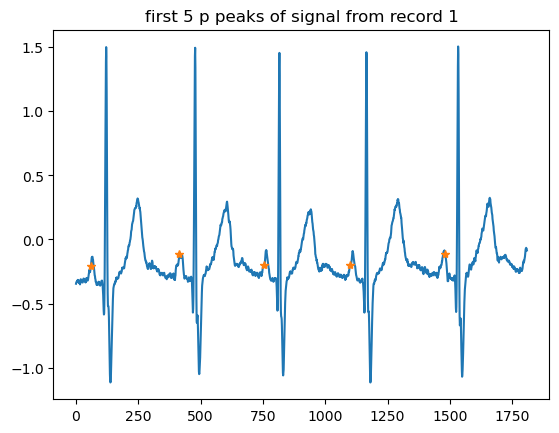

0 is complete


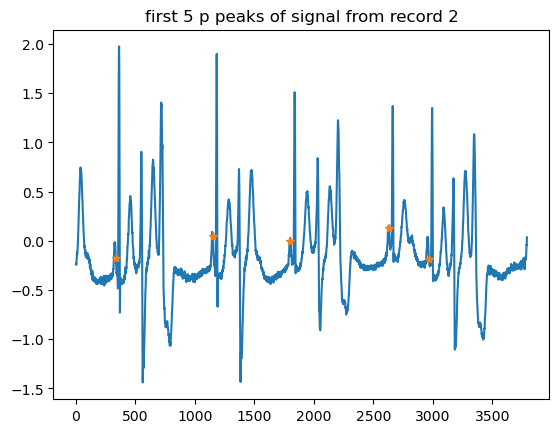

1 is complete


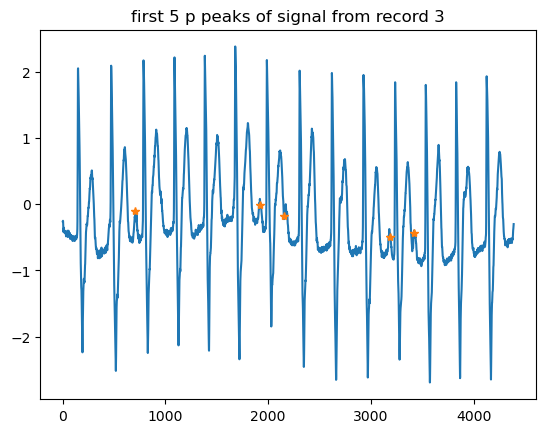

2 is complete


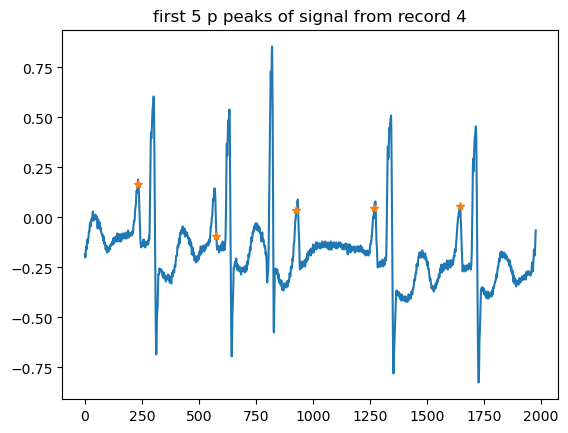

3 is complete


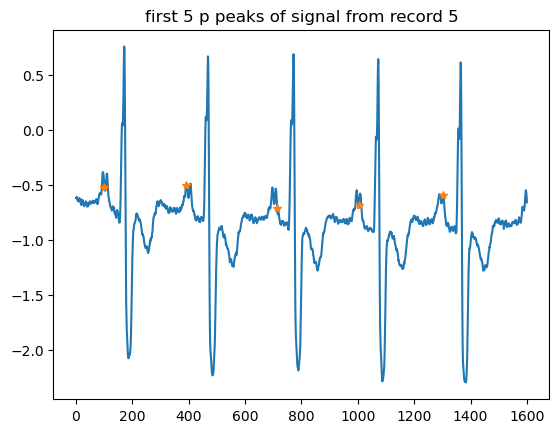

4 is complete


In [4]:
#plot signal and P peaks
for i in range(5):
    plt.title(f'first 5 p peaks of signal from record {i+1}')
    plt.plot(signals[i][:p_anns[i].sample[5]])
    plt.plot(p_anns[i].sample[:5],signals[i][p_anns[i].sample[:5]],'*')
    plt.show()
    print(f'{i} is complete')

## Clean the signals

after plotting the signals, you can see that there are a lot of small and large noises, this function will just slightly smooth it out a bit, which is better for when we are training the model

/opt/conda/lib/python3.11/site-packages/scipy/signal/_filter_design.py:2914: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


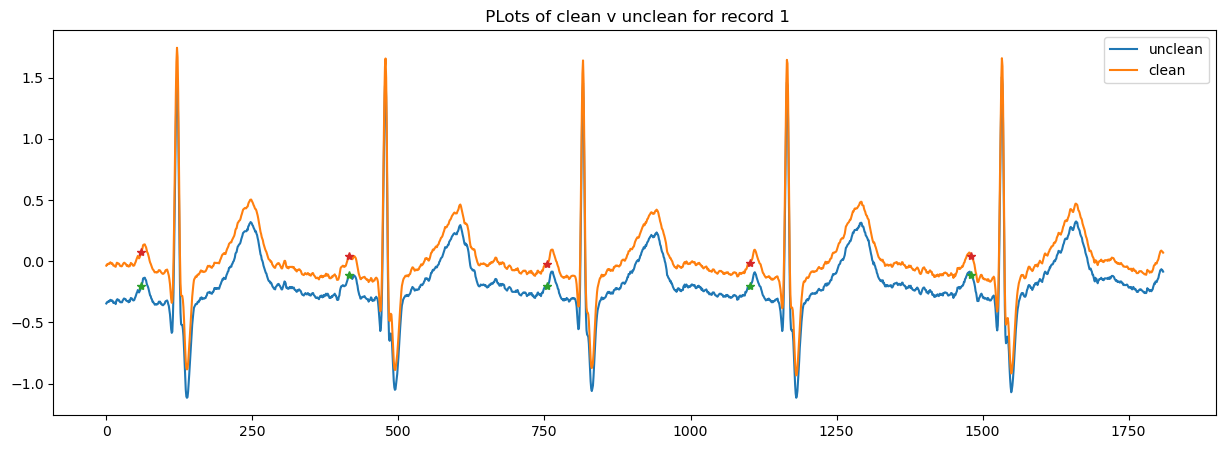

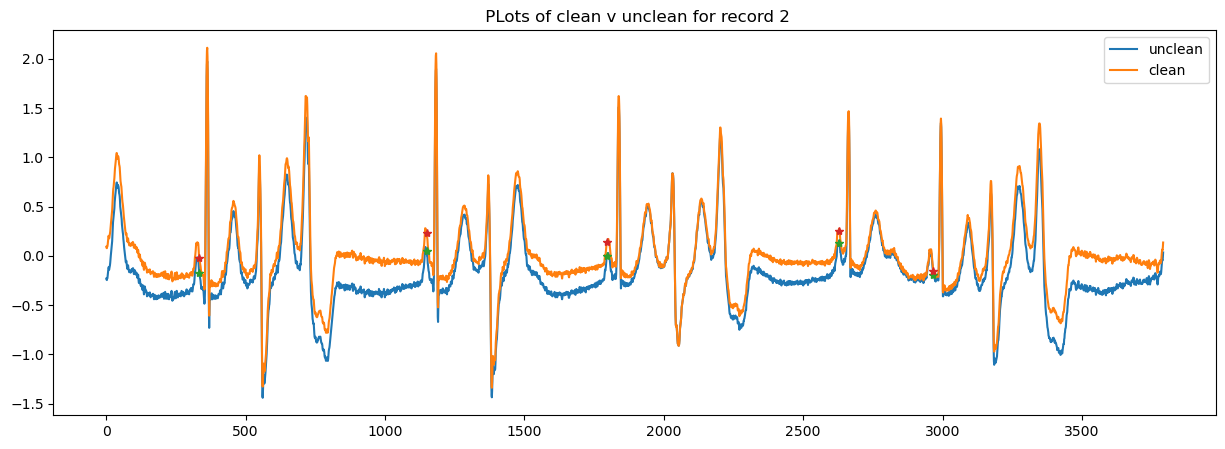

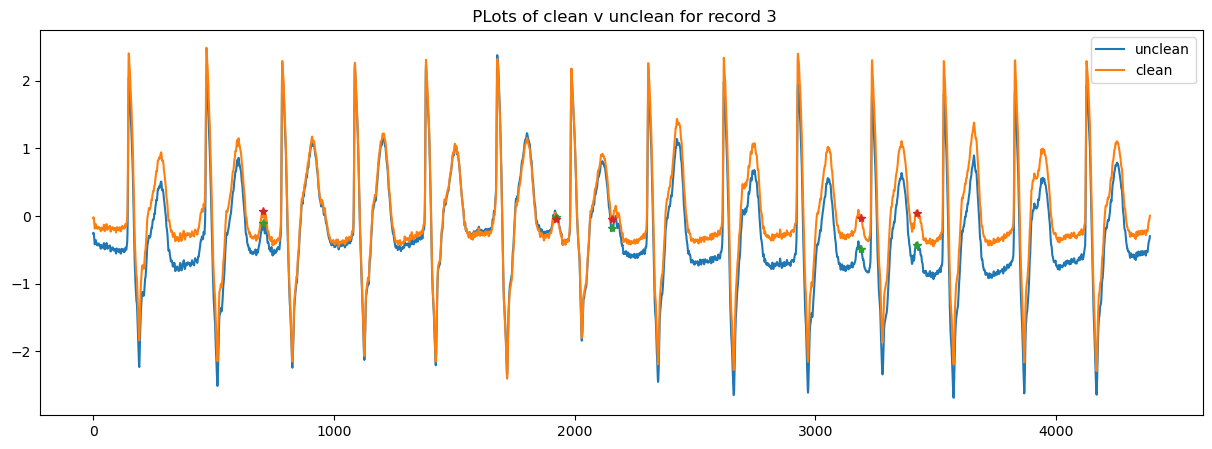

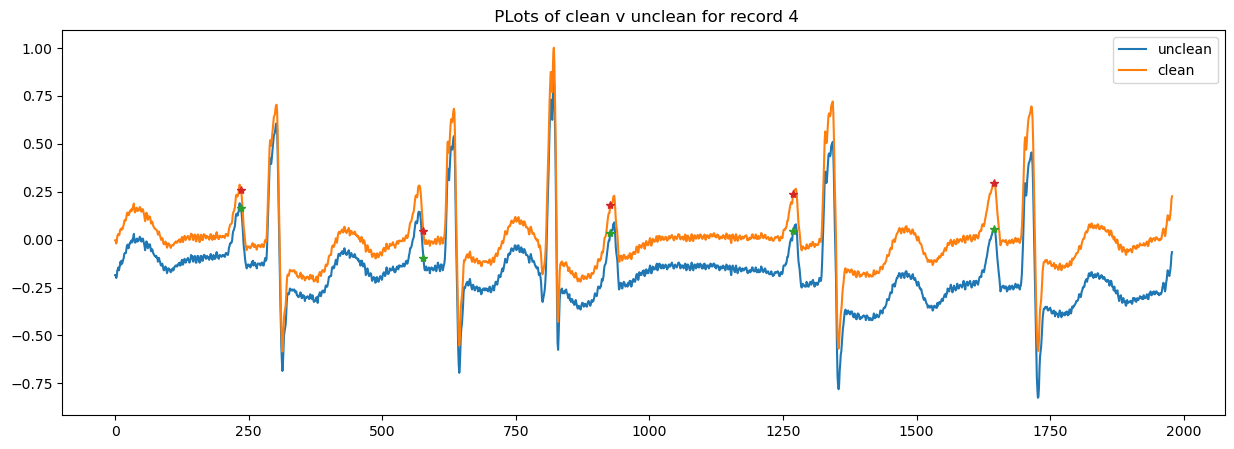

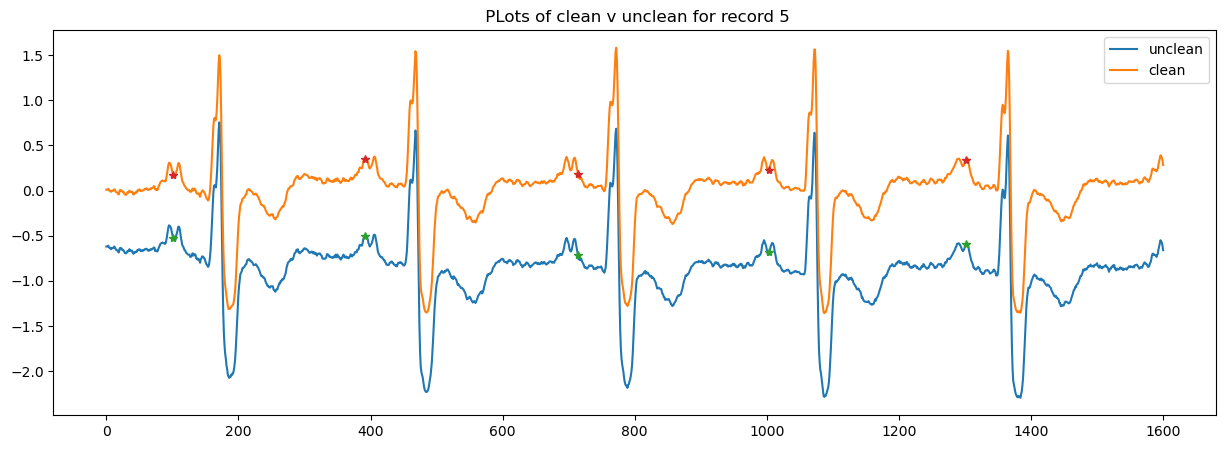

In [5]:
# clean the signals
def cleanTheSignals(signals):
    clean_signals = []
    
    for i in range(len(signals)):
        sig_clean = signals[i].copy()
        sig_clean = sp.filter_X(sig_clean,360,band=[0.5], btype='highpass',ftype='SOS')
        sig_clean = sp.filter_X(sig_clean,360,band=[150], btype='lowpass',ftype='SOS')
    
        clean_signals.append(sig_clean)

    return clean_signals

clean_signals = cleanTheSignals(signals)

for i in range(5):
    #plot signals against each other
    plt.figure(figsize = (15,5))
    plt.title(f' PLots of clean v unclean for record {i+1}')
    
    plt.plot(signals[i][:p_anns[i].sample[5]], label = 'unclean')
    plt.plot(clean_signals[i][:p_anns[i].sample[5]], label = 'clean')
    
    plt.plot(p_anns[i].sample[:5],signals[i][p_anns[i].sample[:5]],'*')
    plt.plot(p_anns[i].sample[:5],clean_signals[i][p_anns[i].sample[:5]],'*')
    
    plt.legend()

## Plot accuracy of P annotations

From the earlier plotting, we could see the R and P peak slightly being off, this section will just test if the annotations for P peak is off. The signal will be plotted by overlapping each other at the P peak annotation. We should see the peaks curve near the middle line.

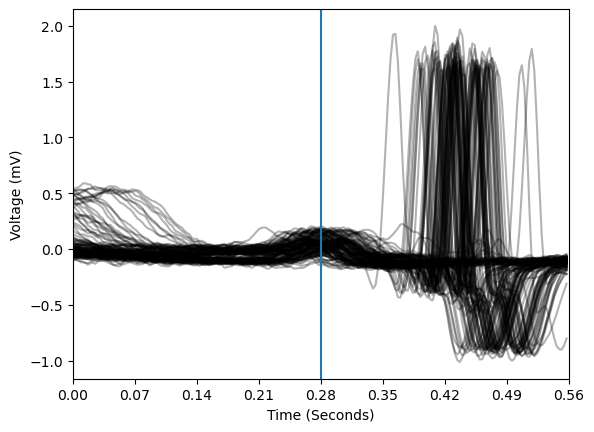

In [14]:
for i in range(len(p_anns[0].sample)):
  plt.plot(clean_signals[0][p_anns[0].sample[i] - 100 : p_anns[0].sample[i] +100], color = 'k', alpha = 0.3)
plt.xlabel("Time (Seconds)")
plt.ylabel("Voltage (mV)")
xticks = plt.xticks()[0]
plt.xticks(xticks, [f"{y/360:.2f}" for y in xticks])
plt.xlim(0,200)
plt.axvline(100)

## Use peak algorithm for one signal

the plot for the P peak annotations had poor results as a lot of peaks were visible away from the vertical line. We use an algorithm to detect the peaks and visualise the results the same way as a direct comparison

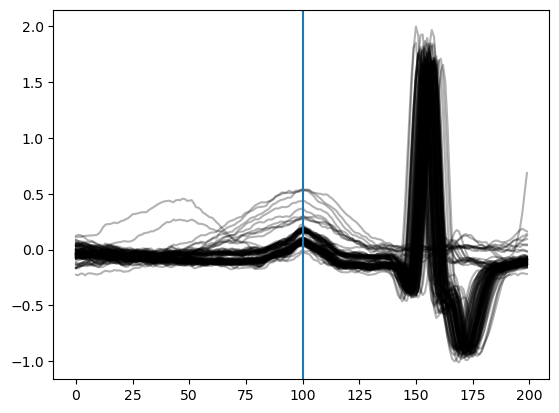

In [7]:
_, rpeaks = nk.ecg_peaks(clean_signals[0], sampling_rate=360)
rpks = rpeaks['ECG_R_Peaks']

# Delineate the ECG signal
_, waves_peak = nk.ecg_delineate(clean_signals[0], rpks, sampling_rate=360, method="peak")

pws = waves_peak['ECG_P_Peaks']

for i in range(len(pws)):
    if pws[i] not in [np.nan]:
        plt.plot(clean_signals[0][pws[i] - 100 : pws[i] +100], color = 'k', alpha = 0.3)
plt.xlabel("Time (Seconds)")
plt.ylabel("Voltage (mV)")
plt.axvline(100)

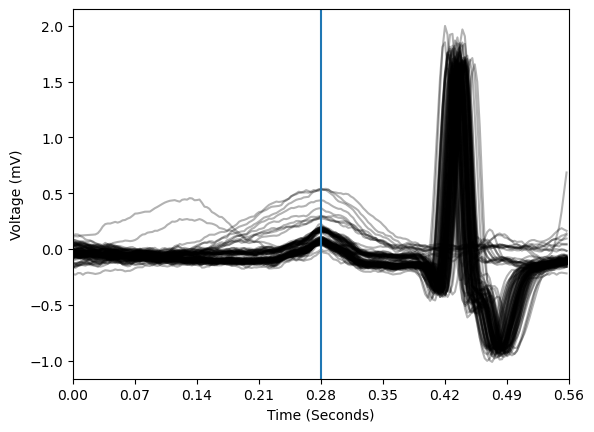

In [15]:
for i in range(len(pws)):
    if pws[i] not in [np.nan]:
        plt.plot(clean_signals[0][pws[i] - 100 : pws[i] +100], color = 'k', alpha = 0.3)
plt.xlabel("Time (Seconds)")
plt.ylabel("Voltage (mV)")
xticks = plt.xticks()[0]
plt.xticks(xticks, [f"{y/360:.2f}" for y in xticks])
plt.xlim(0,200)
plt.axvline(100)

In [ ]:
for i in range(len(pws)):
    if pws[i] not in [np.nan]:
        plt.plot(clean_signals[0][pws[i] - 100 : pws[i] +100], color = 'k', alpha = 0.3)
plt.axvline(100)

## Algorithm to convert all

the algorithm detector had better results than the annotations. Because of this finding, we will overwrite the initial P and R peak annotations, with the peaks the algorithm detected.

In [8]:
def FindP_peaks(signals, fs):
    p_anns =[]
    r_anns= []
    
    for i in range(len(signals)):
        _, rpeaks = nk.ecg_peaks(signals[i], sampling_rate=fs)
        rpks = rpeaks['ECG_R_Peaks']
        
        # Delineate the ECG signal
        _, waves_peak = nk.ecg_delineate(signals[i], rpks, sampling_rate=fs, method="peak")
        
        pws = waves_peak['ECG_P_Peaks']
    
        p_anns.append(pws)
        r_anns.append(rpks)

    return p_anns, r_anns

p_anns, r_anns = FindP_peaks(clean_signals, 360)

## Split signals into beats

This function will split the signal into singular beats as this is what our X input will be. The method will be finding all the R peaks, and slicing in between them to split into a beat

In [9]:
# split into beats
def SplitBeats(p_anns, r_anns, signals):
    #remove all nans
    for i in range(len(p_anns)):
        arr = np.array(p_anns[i])
        cleaned_arr = arr[~np.isnan(arr)] 
        p_anns[i] = cleaned_arr.astype(int).tolist()
        
    beats = []
    p_pks = []
    r_pks = []
    
    for i in range(len(signals)):
        rpks = np.array(r_anns[i], dtype=int)
        ppks = np.array(p_anns[i], dtype=int)
    
        
        #create split lines
        boundaries = np.zeros(len(rpks) + 1, dtype=int)
        for k in range(1, len(rpks)):
            boundaries[k] = (rpks[k - 1] + rpks[k]) // 2
    
        if (p for p in ppks if boundaries[j] <= p < boundaries[j+1]) in [np.nan]:
            print(f' tru and p is {p}')
    
    
       # split the beats and re align p and r peak
        for j in range(len(rpks)):
            beat = signals[i][boundaries[j]: boundaries[j+1]]
            beat = beat - np.mean(beat)
    
            #if there are no p peaks skip
            if len([p - boundaries[j] for p in ppks if boundaries[j] <= p < boundaries[j+1]]) == 0:
                continue
                
            beats.append(beat)
            r_pks.append(rpks[j] - boundaries[j])
            p_pks.append([p - boundaries[j] for p in ppks if boundaries[j] <= p < boundaries[j+1]])

    return beats, p_pks, r_pks

beats, p_pks, r_pks = SplitBeats(p_anns, r_anns, clean_signals)

/opt/conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
/opt/conda/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide


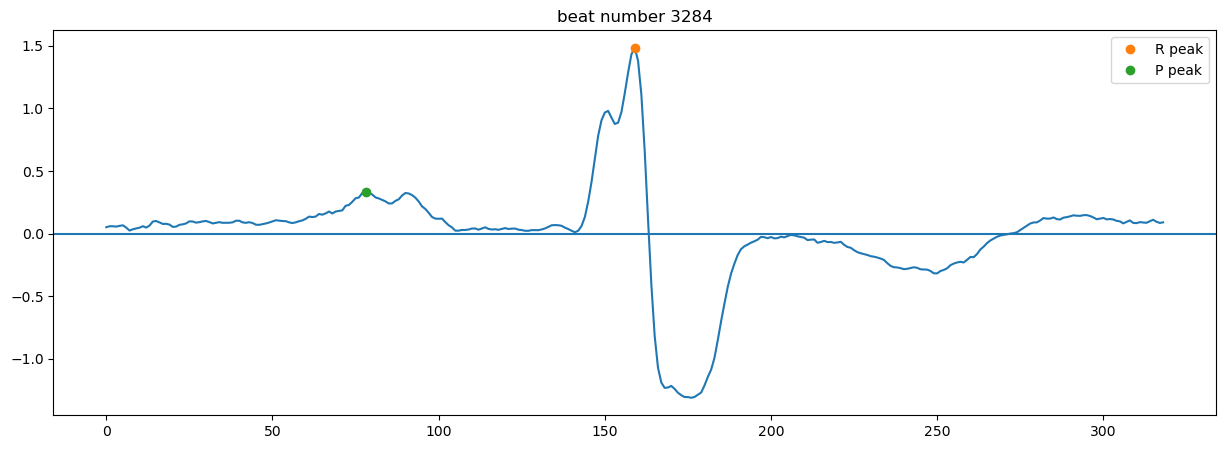

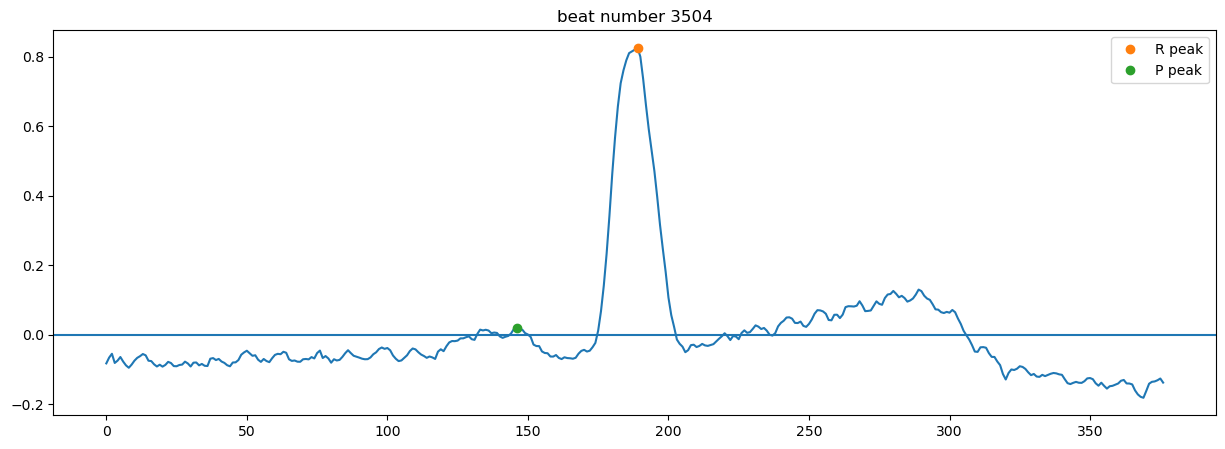

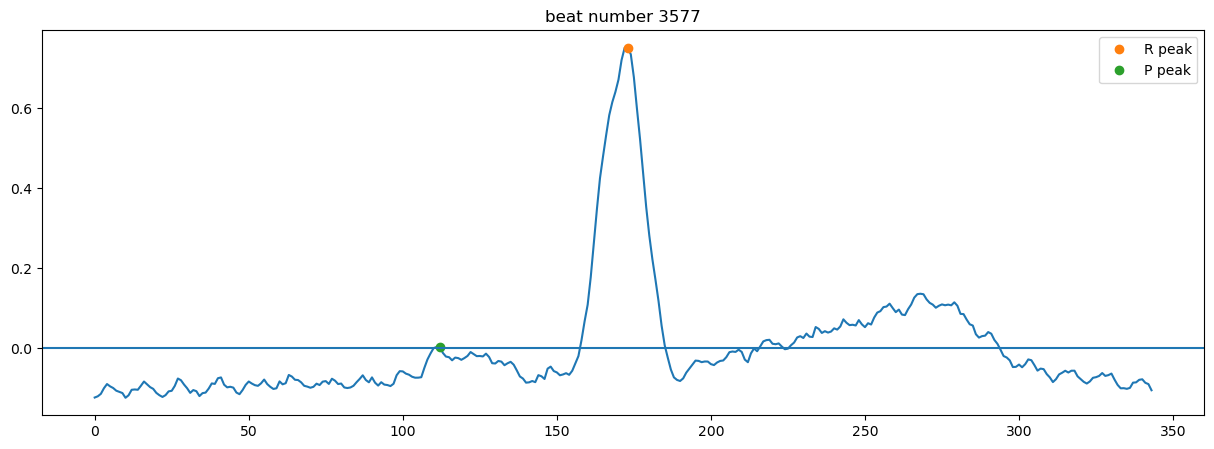

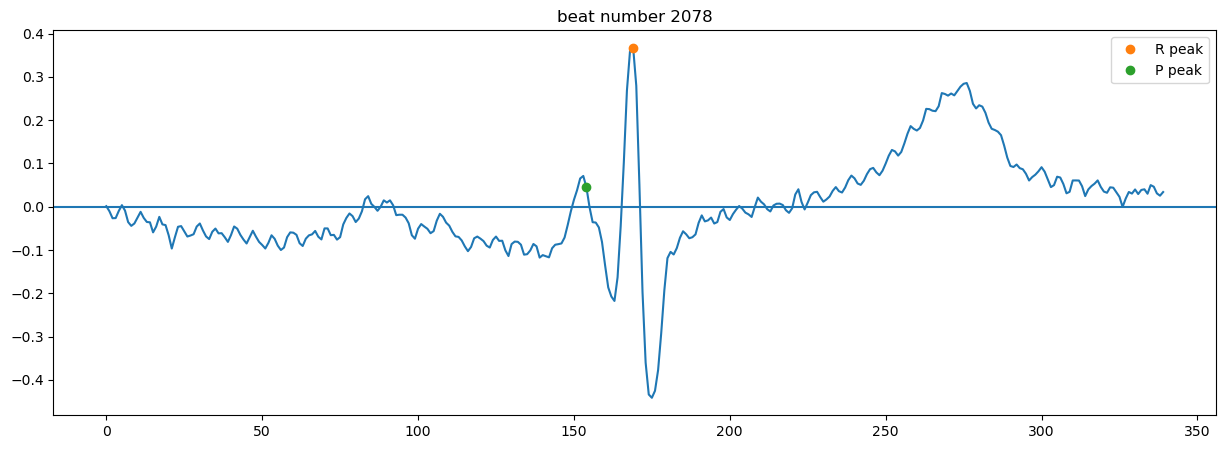

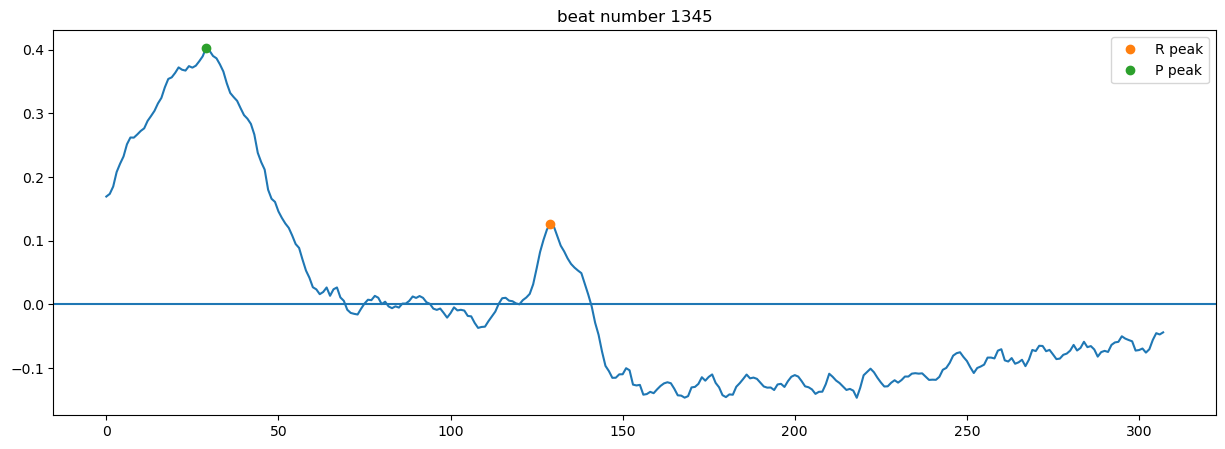

In [10]:
#print 5 random beats
#plot to view accuracy
rand_beat = np.random.randint(1, 5000, size=5)

for i in rand_beat:
    plt.figure(figsize=(15, 5))
    plt.plot(beats[i])
    plt.plot(r_pks[i], beats[i][r_pks[i]], 'o', label='R peak')
    plt.plot(p_pks[i], beats[i][p_pks[i]], 'o', label='P peak')
    plt.title(f'beat number {i}')
    plt.axhline(0)
    plt.legend()

## Split into train and test set

The X will simply be the beats. The y will be the height of the P peak, with the method of our splitting beats, this could result in a beat having 0, 1, or 2 P peaks. if it is 0, we do not add and if its 2 peaks, we only take the height of the first one.

As we split the beats, each will have a different shape, and for the data to be accepted by the model, we padded the end of data with 0s, the length of 0s depended on the data with the largest length, and simple every other data was padded to match tat length.

In [11]:
# split into X and y 

X = beats.copy()
y =[]

for i, p in enumerate(p_pks):
    if len(p) > 0:
        #take only the first p peak
        y.append(beats[i][p[0]])
    else:
        y.append(0.0)

In [12]:
# pad X values as they are different sizes
max_len = max(len(x) for x in X)
X = pad_sequences(
    X, maxlen=max_len, dtype="float32",
    padding="post", value=0.000
)[..., np.newaxis]   
y = np.array(y, dtype="float32")

In [13]:
indices = np.arange(len(p_pks))
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, indices, test_size=0.2, random_state=42)
beats_ppks_train = [p_pks[i] for i in idx_train]
beats_ppks_test  = [p_pks[i] for i in idx_test]

# Model Architecture

## Architecture

The model architecture consisted of multiple convolutional, maxPooling, Dropout and BatchNormalization layer. This was done to find the best balance between learning but not overtraining.

As we have padding, a mask was created to ignore all features learnt where the data is 0. As Max pooling and BatchNormalization decreased the data size, we had to also decrease the mask size, so we can multiply them at the end

In [14]:
# Inputs & mask
inp  = layers.Input(shape=(None, 1))
mask = tf.cast(tf.not_equal(inp, 0.0), tf.float32)  # shape=(batch, T, 1)
x    = inp

# Conv‐pool blocks
x    = layers.Conv1D(64, 5, strides=2, padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-5))(x)
mask = layers.MaxPooling1D(pool_size=2, strides=2, padding="same")(mask)
x    = layers.Dropout(0.1)(x)
x    = layers.BatchNormalization()(x)
x    = layers.MaxPooling1D(pool_size=2, padding="same")(x)
mask = layers.MaxPooling1D(pool_size=2, padding="same")(mask)

x    = layers.Conv1D(128, 5, strides=2, padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-6))(x)
mask = layers.MaxPooling1D(pool_size=2, strides=2, padding="same")(mask)
x    = layers.Dropout(0.2)(x)
x    = layers.BatchNormalization()(x)
x    = layers.MaxPooling1D(pool_size=2, padding="same")(x)
mask = layers.MaxPooling1D(pool_size=2, padding="same")(mask)

x    = layers.Conv1D(256, 5, strides=1, padding="same", activation="relu", kernel_regularizer=regularizers.l2(1e-7))(x)
x    = layers.Dropout(0.3)(x)
x    = layers.BatchNormalization()(x)
x    = layers.MaxPooling1D(pool_size=2, padding="same")(x)
mask = layers.MaxPooling1D(pool_size=2, padding="same")(mask)

# apply mask
x = layers.Multiply()([x, mask])

# global pooling
x = layers.GlobalAveragePooling1D()(x)

#dense layers
x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.3)(x)

out = layers.Dense(1, activation="linear")(x)

# compile
model = models.Model(inputs=inp, outputs=out)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=["mae"]
)

In [15]:
model.load_weights('ecg_regression_trained.h5')

## Model plots

show accuracy of model 

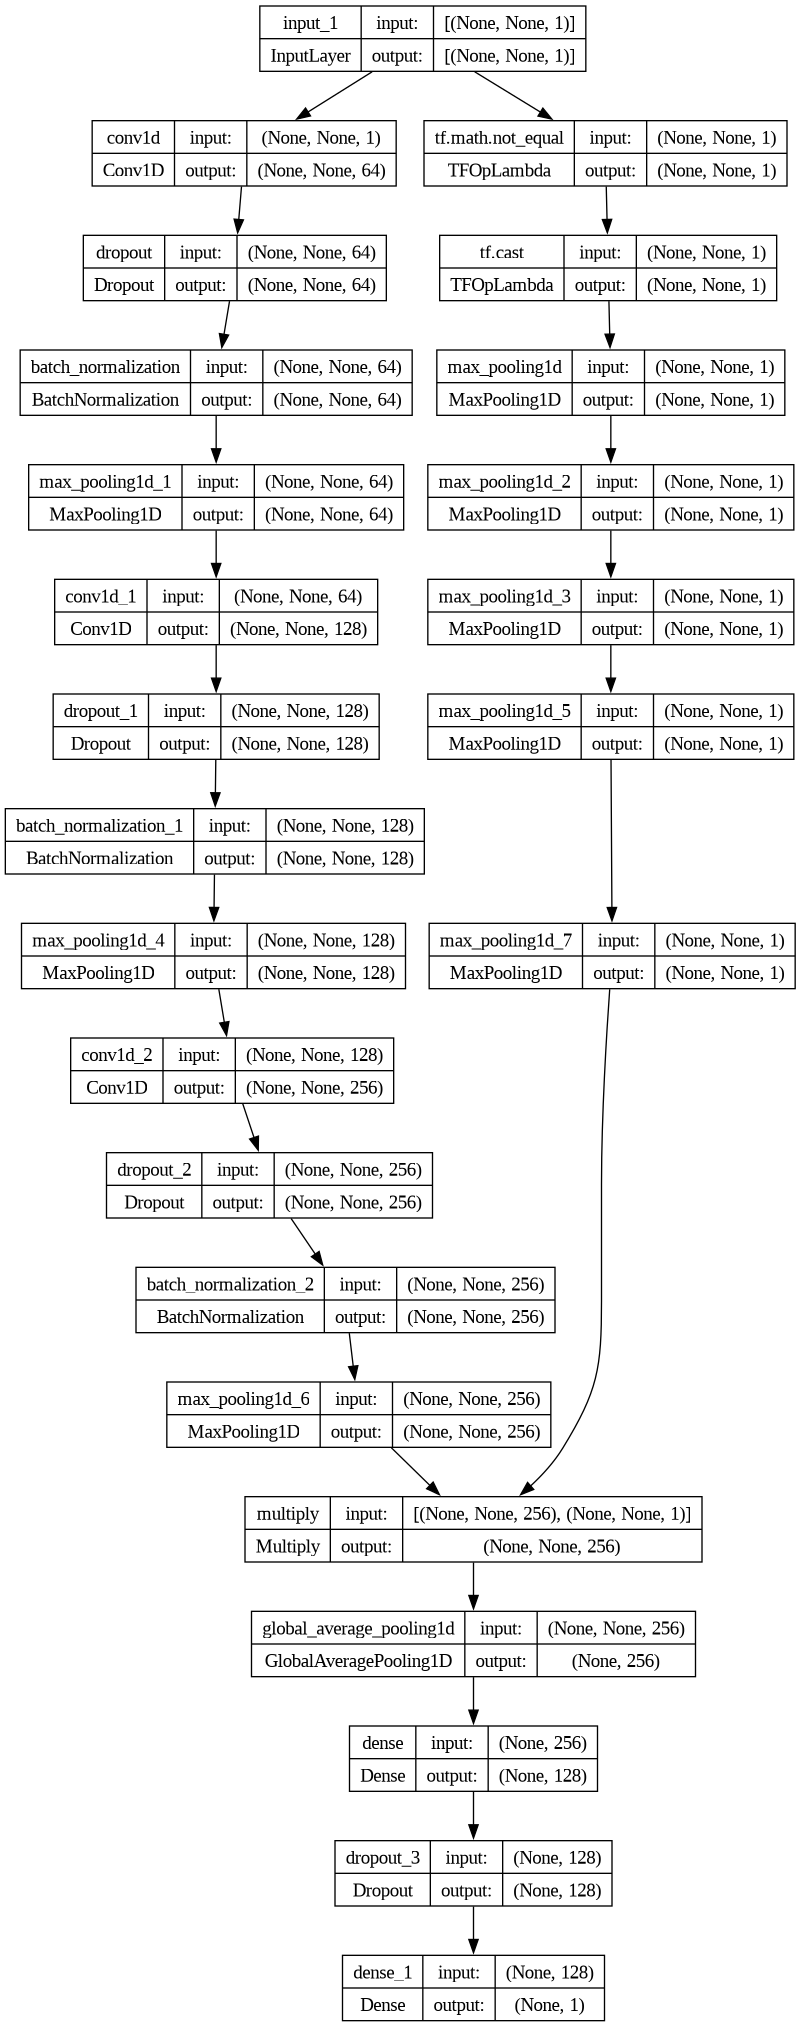

In [18]:
dot_img_file = 'model_1.png'
plot_model(model, to_file=dot_img_file,  show_shapes=True)

In [31]:
with open('training_history.json') as f:
    hist = json.load(f)

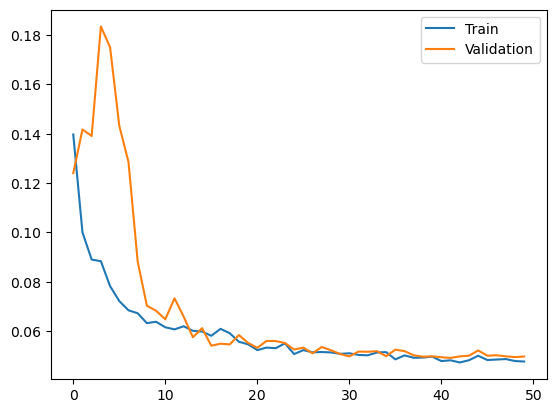

In [32]:
plt.plot(hist['mae'], label = 'Train')
plt.plot(hist['val_mae'], label = 'Validation')
plt.legend()


In [33]:

y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2: ", r2_score(y_test, y_pred))


29/29 [==============================] - 1s 7ms/step
MAE: 0.05136054754257202
MSE: 0.007969609461724758
R2:  0.7196193337440491


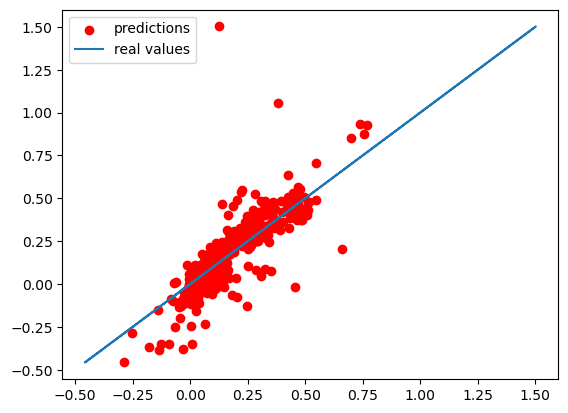

In [35]:
plt.scatter(y_pred, y_test, color = 'red', label = 'predictions')
plt.plot(y_test, y_test, label = 'real values')
plt.legend()

# Saliency maps

## Load new records

For the saliency maps, I will use signals from the same dataset, but that were not used in the training. This is to remove any bias that may exits. The next few cells contains code that goes puts the data through the same preprocess methods as before

In [36]:
signals_sal = []
p_anns_sal = []
r_anns_sal = []

for rec in ['36', '37']:
    record =  wfdb.rdrecord(rec, pn_dir = database)
    
    sig = record.p_signal[:,0]
    p_ann = wfdb.rdann(f"{int(rec):02}", 'pwave', pn_dir=database)
    if len(p_ann.sample) < 10:
        continue
    r_ann = wfdb.rdann(f"{int(rec):02}", 'qrs', pn_dir = database)

    print(f"Record being collected is record number: {int(rec):02}")
    #store signals and annotations
    signals_sal.append(sig)
    p_anns_sal.append(p_ann)
    r_anns_sal.append(r_ann)

Record being collected is record number: 36
Record being collected is record number: 37


In [37]:
signals_sal = cleanTheSignals(signals_sal)
p_anns_sal, r_anns_sal = FindP_peaks(signals_sal, 360)
beats_sal, p_pks_sal, r_pks_sal = SplitBeats(p_anns_sal, r_anns_sal, signals_sal)

/opt/conda/lib/python3.11/site-packages/scipy/signal/_filter_design.py:2914: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/opt/conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
/opt/conda/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide


In [38]:
labels_sal = []

for i, p in enumerate(p_pks_sal):
    if len(p) > 0:
        #take only the first p peak
        labels_sal.append(beats_sal[i][p[0]])
    else:
        labels_sal.append(0.0)

In [39]:
len(beats_sal) == len(r_pks_sal) == len(p_pks_sal) ==len(labels_sal)

True

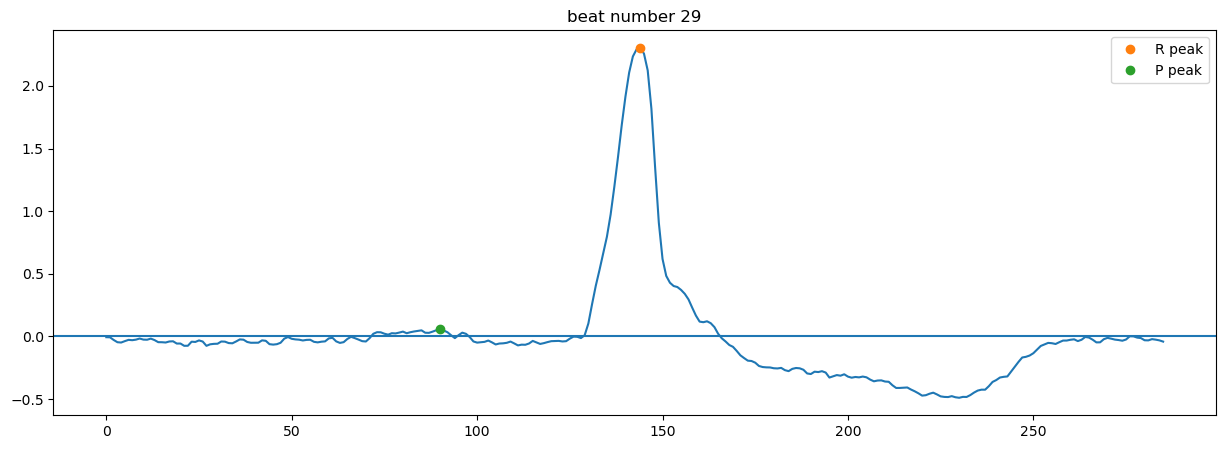

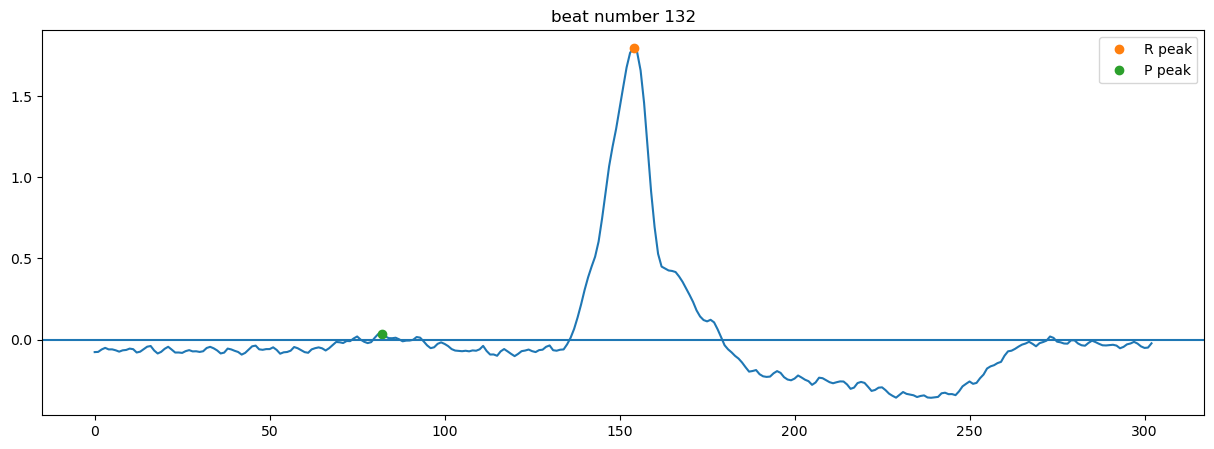

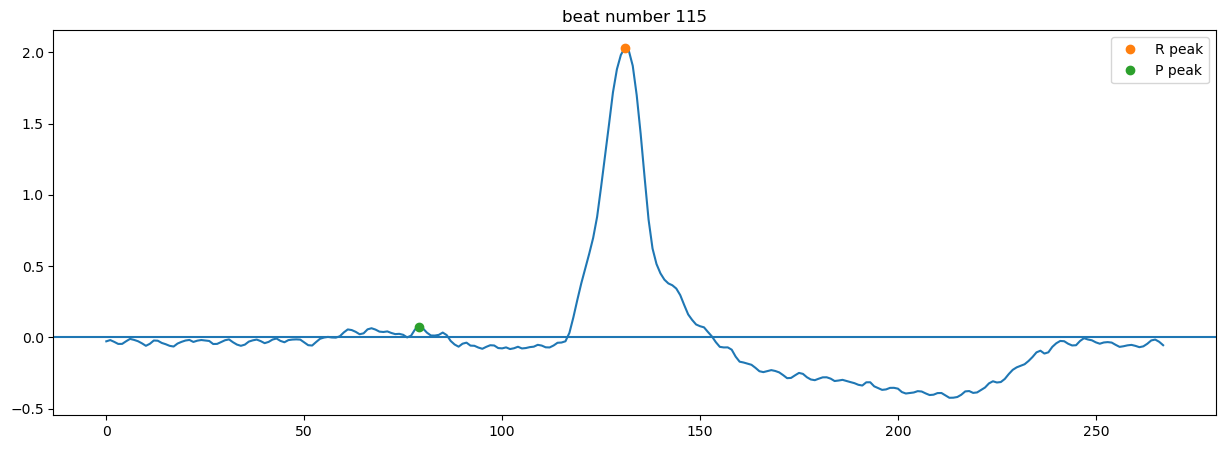

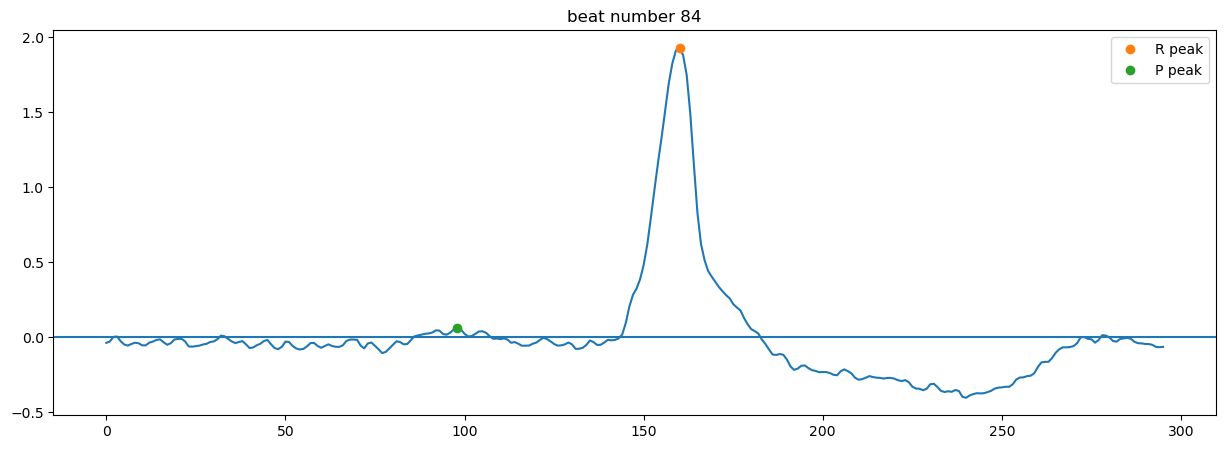

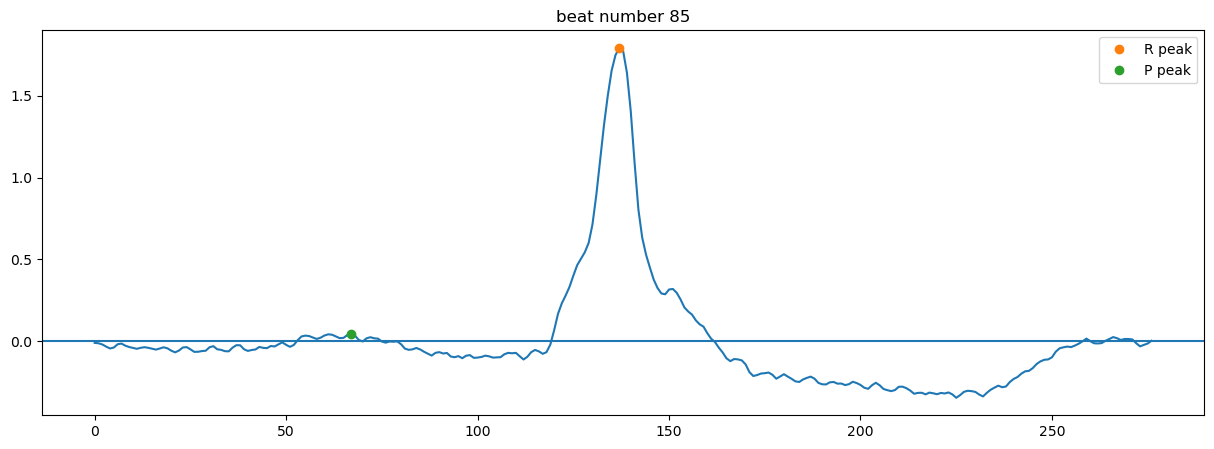

In [40]:
#print 5 random beats

rand_beat = np.random.randint(1, 241, size=5)

for i in rand_beat:
    plt.figure(figsize=(15, 5))
    plt.plot(beats_sal[i])
    plt.plot(r_pks_sal[i], beats_sal[i][r_pks_sal[i]], 'o', label='R peak')
    plt.plot(p_pks_sal[i], beats_sal[i][p_pks_sal[i]], 'o', label='P peak')
    plt.title(f'beat number {i}')
    plt.axhline(0)
    plt.legend()

In [41]:
max_len = max(len(x) for x in beats_sal)
beats_sal = pad_sequences(
    beats_sal, maxlen=max_len, dtype="float32",
    padding="post", value=0.000
)[..., np.newaxis]   
labels_sal = np.array(labels_sal, dtype="float32")

## Definitions for saliency maps

This section will hold what all the different types of saliency maps will need. The score, samples, labels, peaks and predictions will be defined here in order to not re use the same code multiple times

In [49]:
def score(inputs):
    return model(inputs)

# def score(output):
#     return output[:, 0]  # If your output shape is (batch, 1)

random_int = np.random.randint(0, len(beats_sal), size = 5)
samples = np.stack([beats_sal[i] for i in random_int])
labels = np.stack([labels_sal[i] for i in random_int])
peaks = np.stack([p_pks_sal[i] for i in random_int])

preds = model.predict(samples).squeeze()

1/1 [==============================] - 0s 19ms/step


## Vanilla saliency

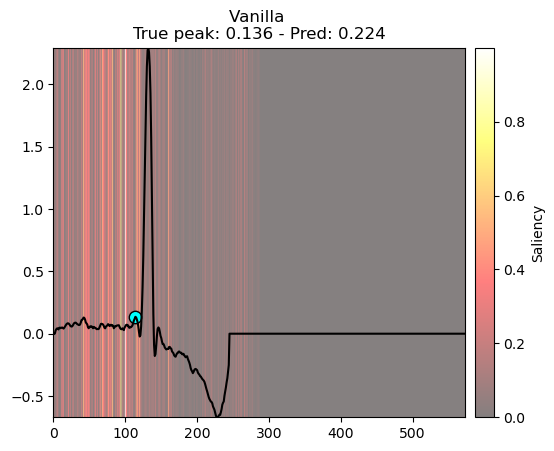

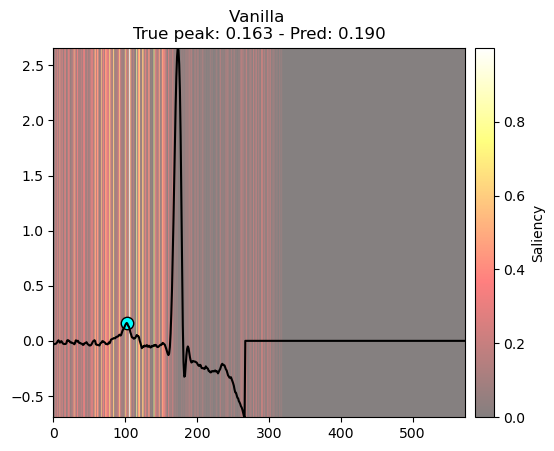

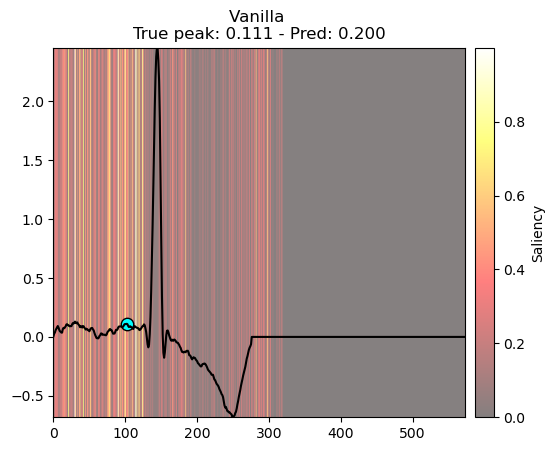

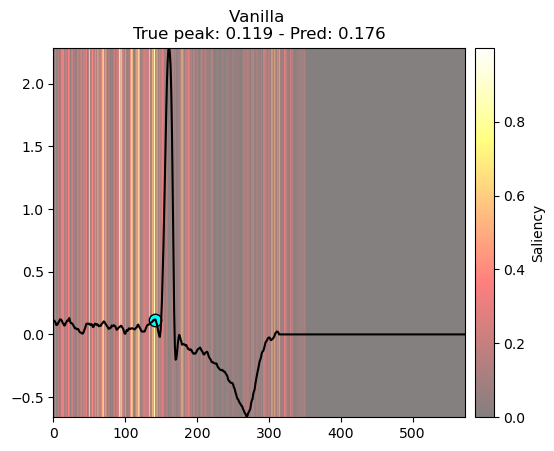

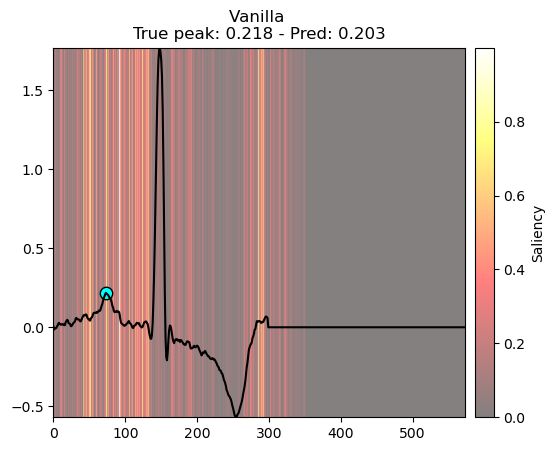

In [61]:
#Create Saliency object.
van_saliency = Saliency(model, model_modifier=None, clone=True)
vanilla_saliency_map = van_saliency(score, samples)

for i in range(len(samples)):
    im = plt.imshow(
    np.vstack([vanilla_saliency_map[i], vanilla_saliency_map[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
    origin='lower'
    )
    plt.plot(samples[i, :, 0], color='black', label='ECG')
    plt.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    plt.colorbar(im, label='Saliency', pad=0.02)
    plt.title(f"Vanilla \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
    plt.show()

/tmp/ipykernel_21761/3291186524.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


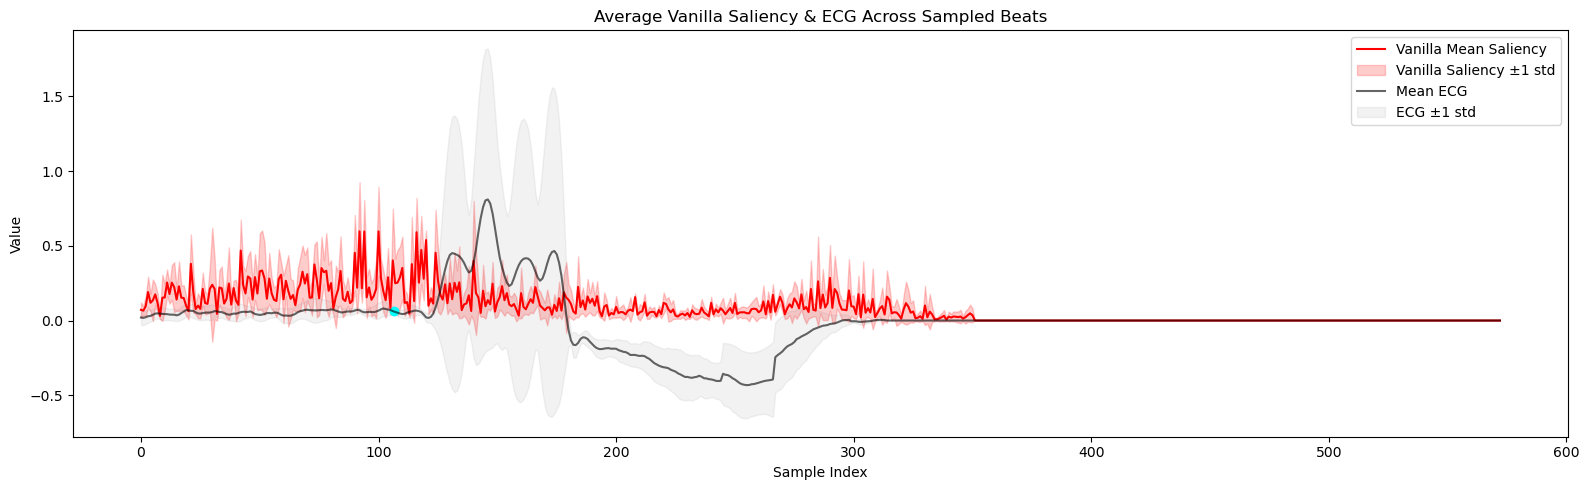

In [57]:
#plot the average ecg and saliency map
vanilla_mean_saliency = np.mean(vanilla_saliency_map, axis=0)
vanilla_std_saliency = np.std(vanilla_saliency_map, axis=0)

vanilla_mean_ecg = np.mean(samples[:, :, 0], axis=0)
vanilla_std_ecg = np.std(samples[:, :, 0], axis=0)

vanilla_mean_peaks = np.mean(peaks[:], axis = 0)

x = np.arange(vanilla_mean_saliency.shape[0])

plt.figure(figsize=(16, 5))
plt.plot(x, vanilla_mean_saliency, color='red', label='Vanilla Mean Saliency')
plt.fill_between(x,vanilla_mean_saliency - vanilla_std_saliency,vanilla_mean_saliency + vanilla_std_saliency,color='red', alpha=0.2, label='Vanilla Saliency ±1 std')

plt.plot(x, vanilla_mean_ecg, color='black', label='Mean ECG', alpha=0.6)
plt.fill_between(x, vanilla_mean_ecg - vanilla_std_ecg, vanilla_mean_ecg + vanilla_std_ecg,color='gray', alpha=0.1, label='ECG ±1 std')


plt.scatter(vanilla_mean_peaks, vanilla_mean_ecg[int(vanilla_mean_peaks)], color = 'cyan')

plt.title('Average Vanilla Saliency & ECG Across Sampled Beats')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()


## SmoothGrad

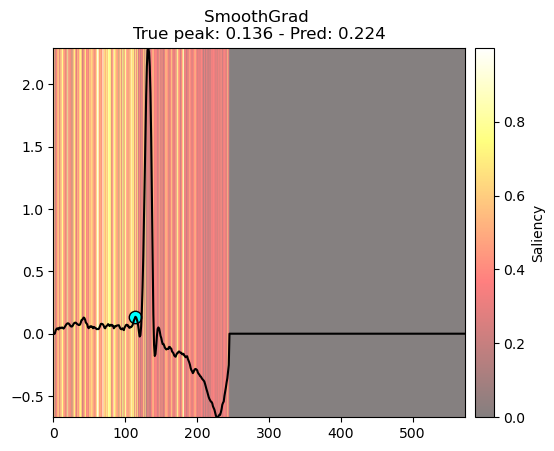

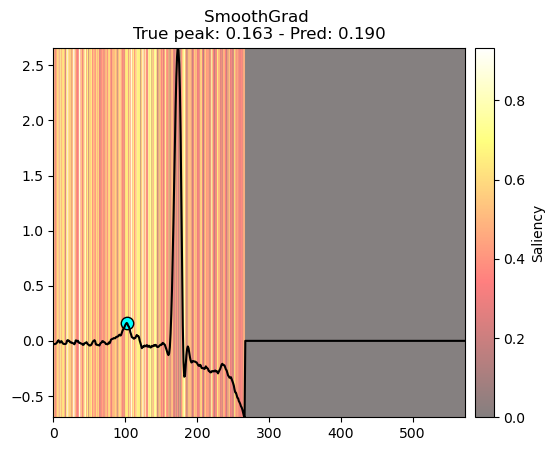

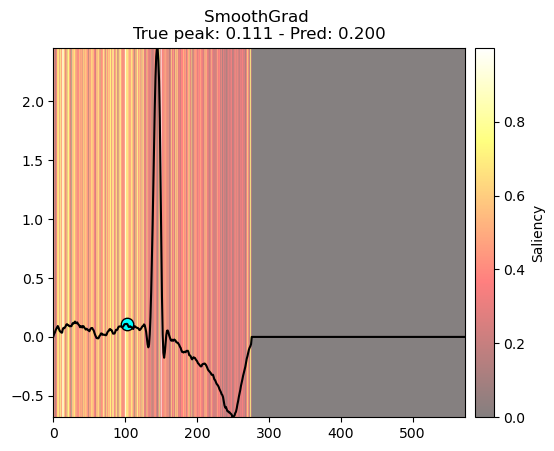

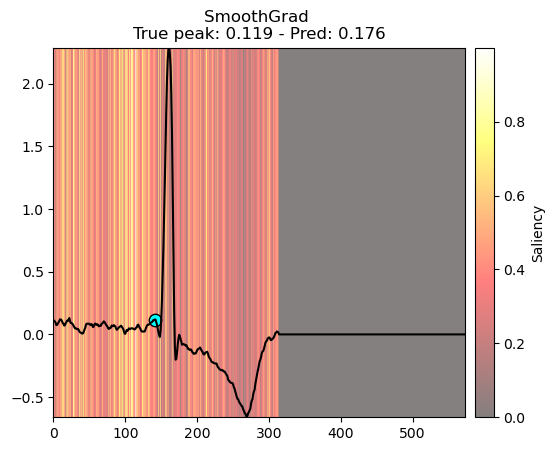

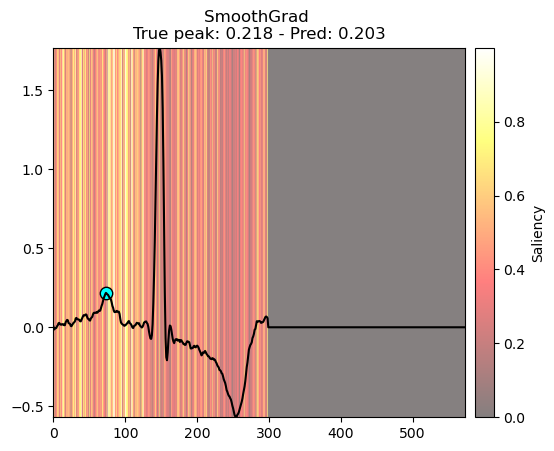

In [62]:
# Generate saliency map with smoothing that reduce noise by adding noise
sg_saliency = Saliency(model, model_modifier=None, clone=True)
sg_saliency_map = sg_saliency(
    score,
    samples,
    smooth_samples=20,  # The number of calculating gradients iterations.
    smooth_noise=0.20)  # noise spread level.

# After computing sg_saliency_map
mask_np = (samples != 0).astype(np.float32)  # 1 where real data, 0 where padding
mask_np = np.squeeze(mask_np, axis=-1)       # Remove channel dimension if present

sg_saliency_map = np.copy(sg_saliency_map)
sg_saliency_map[mask_np == 0] = 0

for i in range(len(samples)):
    im = plt.imshow(
    np.vstack([sg_saliency_map[i], sg_saliency_map[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
    origin='lower'
    )
    plt.plot(samples[i, :, 0], color='black', label='ECG')
    plt.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    plt.colorbar(im, label='Saliency', pad=0.02)
    plt.title(f"SmoothGrad \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
    plt.show()

/tmp/ipykernel_21761/443855927.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


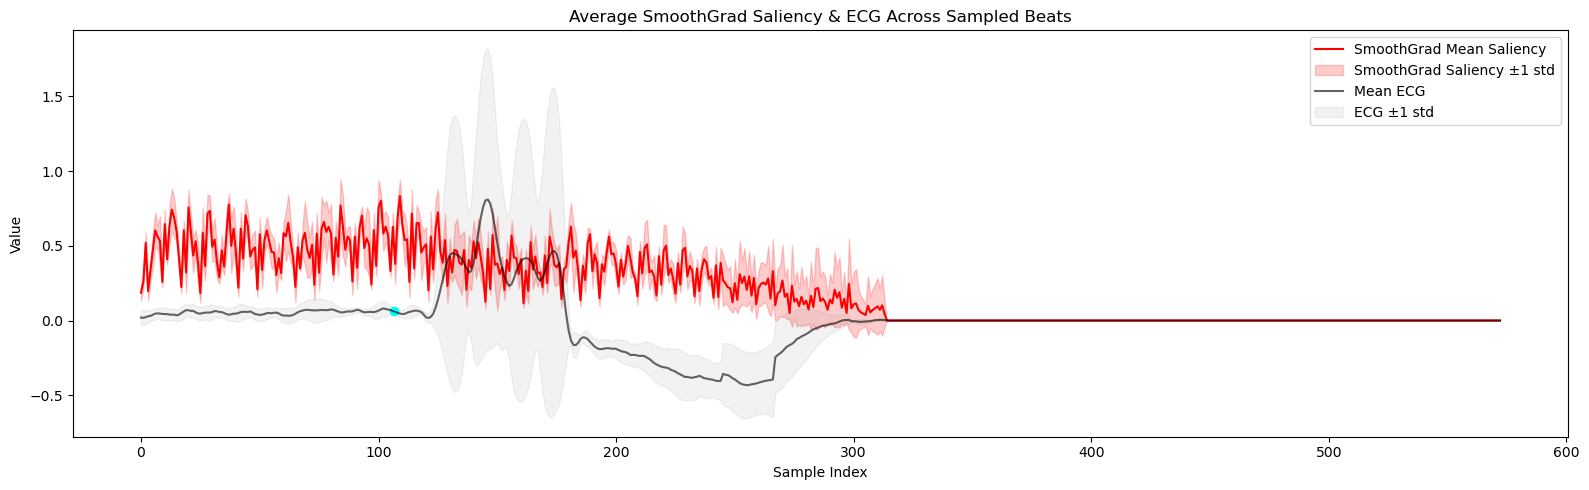

In [66]:
sg_mean_saliency = np.mean(sg_saliency_map, axis=0)
sg_std_saliency = np.std(sg_saliency_map, axis=0)

sg_mean_ecg = np.mean(samples[:, :, 0], axis=0)
sg_std_ecg = np.std(samples[:, :, 0], axis=0)

sg_mean_peaks = np.mean(peaks[:], axis = 0)

x = np.arange(sg_mean_saliency.shape[0])

plt.figure(figsize=(16, 5))
plt.plot(x, sg_mean_saliency, color='red', label='SmoothGrad Mean Saliency')
plt.fill_between(x,sg_mean_saliency - sg_std_saliency,sg_mean_saliency + sg_std_saliency,color='red', alpha=0.2, label='SmoothGrad Saliency ±1 std')

plt.plot(x, sg_mean_ecg, color='black', label='Mean ECG', alpha=0.6)
plt.fill_between(x, sg_mean_ecg - sg_std_ecg, sg_mean_ecg + sg_std_ecg,color='gray', alpha=0.1, label='ECG ±1 std')


plt.scatter(sg_mean_peaks, sg_mean_ecg[int(sg_mean_peaks)], color = 'cyan')

plt.title('Average SmoothGrad Saliency & ECG Across Sampled Beats')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()


## GradCAM

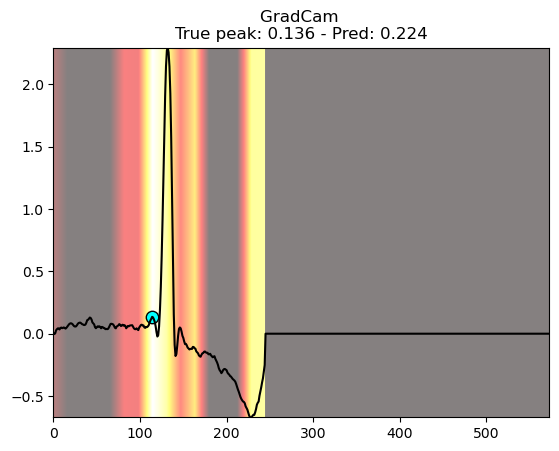

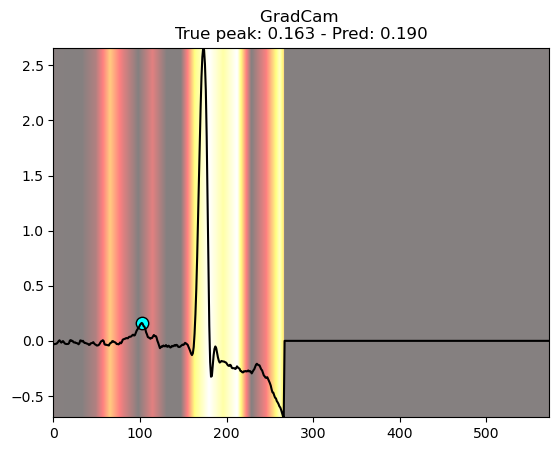

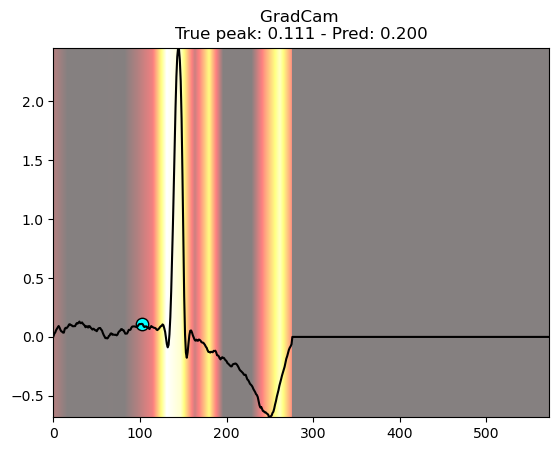

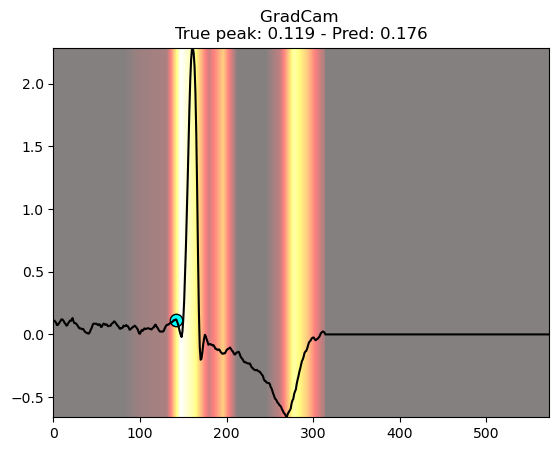

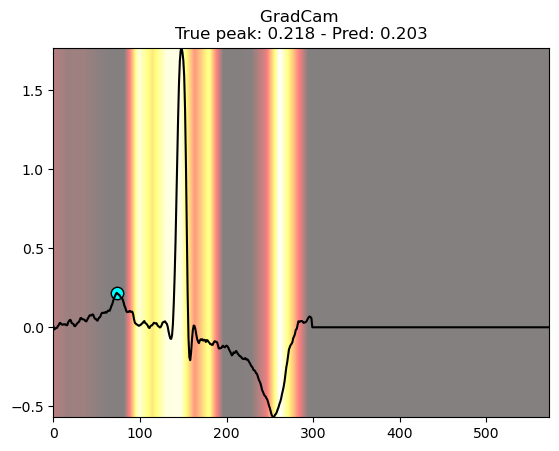

In [65]:
# Get the penultimate Conv1D layer (can use index or layer name)
penultimate_layer = 'conv1d_2'

# Create GradCAM object
gradcam = Gradcam(model, model_modifier=None, clone=True)

# Generate cam
cam = gradcam(score, samples, penultimate_layer=penultimate_layer)

# After computing sg_saliency_map
mask_cam = (samples != 0).astype(np.float32)  # 1 where real data, 0 where padding
mask_cam = np.squeeze(mask_cam, axis=-1)       # Remove channel dimension if present

cam = np.copy(cam)
cam[mask_cam == 0] = 0

# cam: (batch, steps), usually steps < input length
# Interpolate cam to match input length if needed:

cam_resized = np.array([
    scipy.ndimage.zoom(c, samples.shape[1] / c.shape[0], order=1)
    for c in cam
])

for i in range(len(samples)):
    plt.imshow(
    np.vstack([cam_resized[i], cam_resized[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
    origin='lower'
    )
    plt.plot(samples[i, :, 0], color='black', label='ECG')
    plt.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    
    plt.title(f"GradCam \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
    
    plt.show()

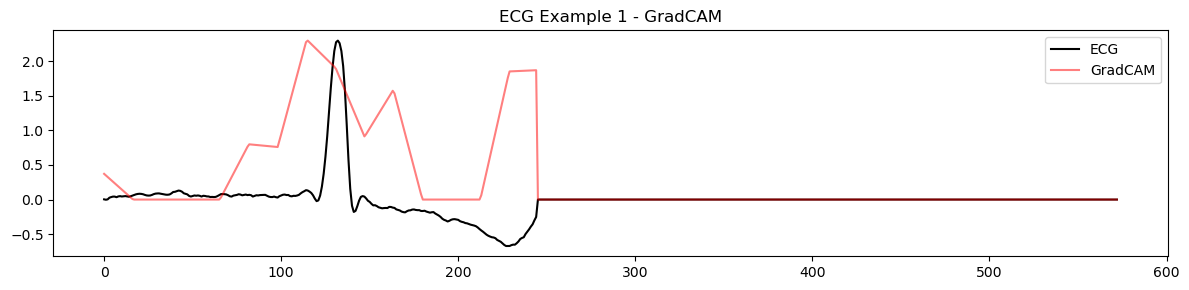

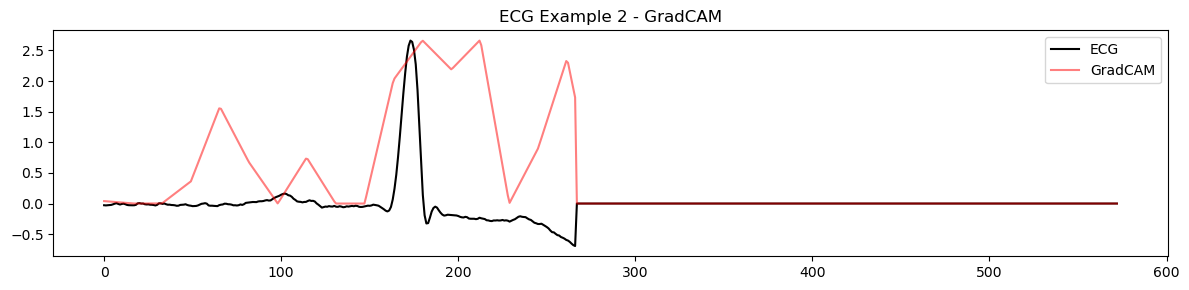

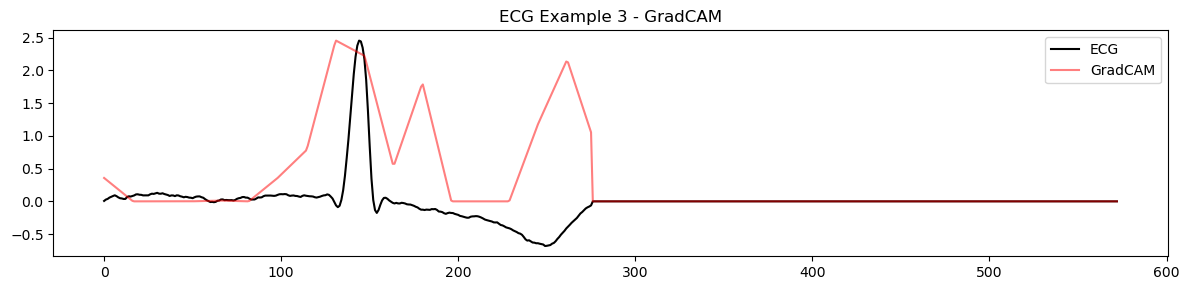

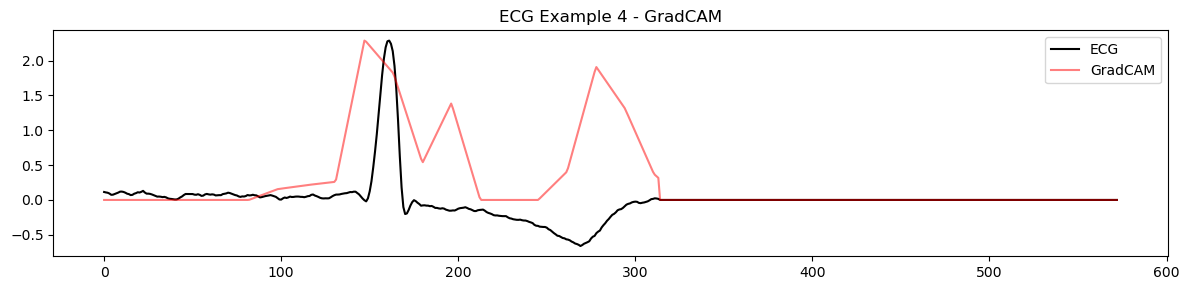

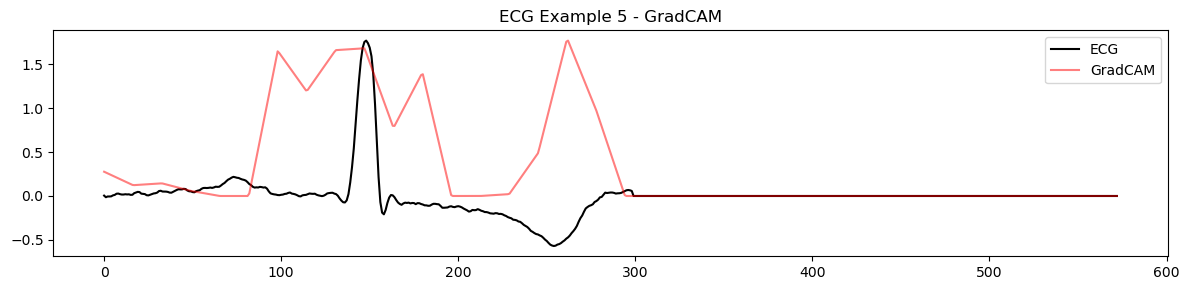

In [67]:
for i in range(len(samples)):
    plt.figure(figsize=(12, 3))
    plt.title(f"ECG Example {i+1} - GradCAM")
    plt.plot(samples[i, :, 0], color='black', label='ECG')
    plt.plot(cam_resized[i] / cam_resized[i].max() * samples[i, :, 0].max(),  # scale heatmap to waveform
             color='red', alpha=0.5, label='GradCAM')
    plt.legend()
    plt.tight_layout()
    plt.show()


## GradCAM ++

0.0 0.99999976


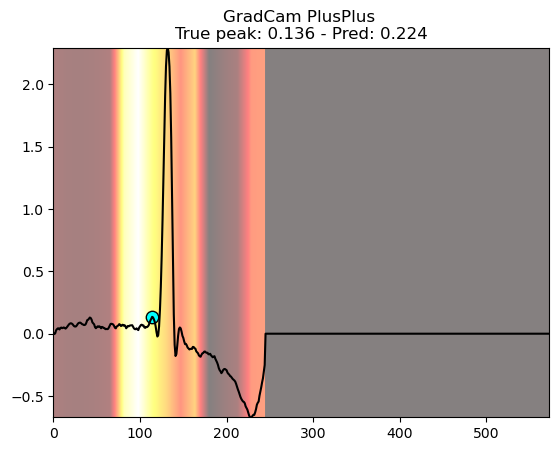

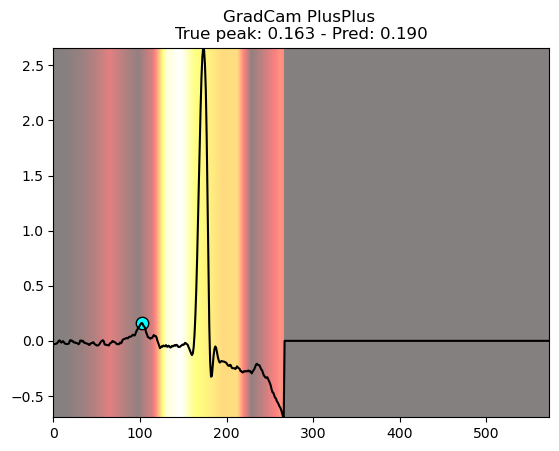

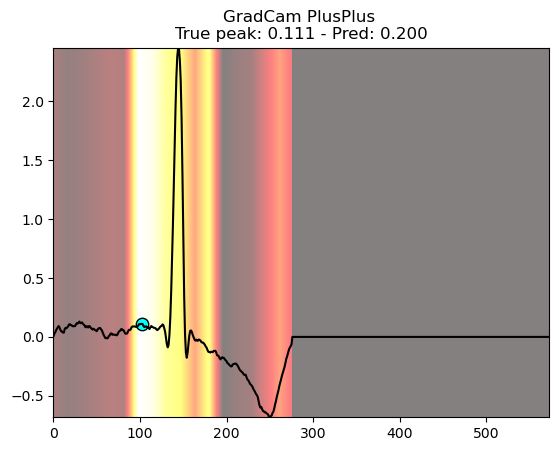

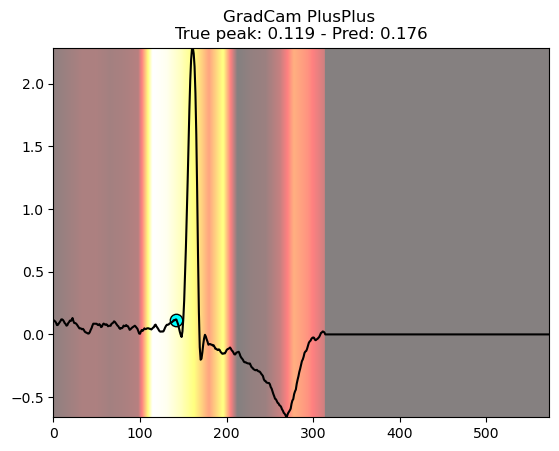

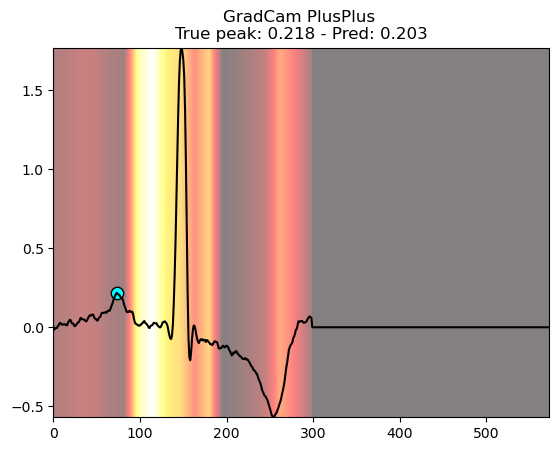

In [68]:
# Create GradCAM++ object
gradcam_plus = GradcamPlusPlus(model, model_modifier=None, clone=True)

# Generate heatmap with GradCAM++
cam_plus = gradcam_plus(score, samples, penultimate_layer =  penultimate_layer)

# After computing sg_saliency_map
mask_cam_plus = (samples != 0).astype(np.float32)  # 1 where real data, 0 where padding
mask_cam_plus = np.squeeze(mask_cam_plus, axis=-1)       # Remove channel dimension if present

cam_plus = np.copy(cam_plus)
cam_plus[mask_cam_plus == 0] = 0

# cam: (batch, steps), usually steps < input length
# Interpolate cam to match input length if needed:
import scipy.ndimage

cam_plus_resized = np.array([
    scipy.ndimage.zoom(c, samples.shape[1] / c.shape[0], order=1)
    for c in cam_plus
])
cam_plus_resized = np.array([
    scipy.ndimage.zoom(c, samples.shape[1] / c.shape[0], order=1)
    for c in cam_plus
])

print(np.nanmin(cam_plus_resized), np.nanmax(cam_plus_resized))
for i in range(len(samples)):
    plt.imshow(
    np.vstack([cam_plus_resized[i], cam_plus_resized[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
    origin='lower'
    )
    plt.plot(samples[i, :, 0], color='black', label='ECG')
    plt.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    
    plt.title(f"GradCam PlusPlus \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
    
    plt.show()

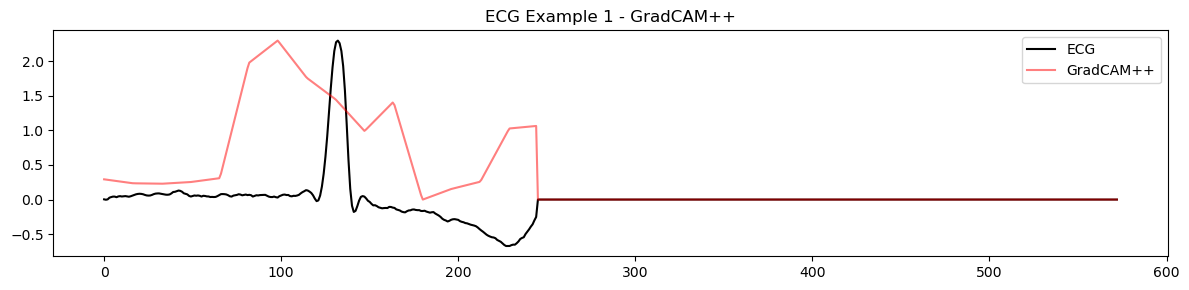

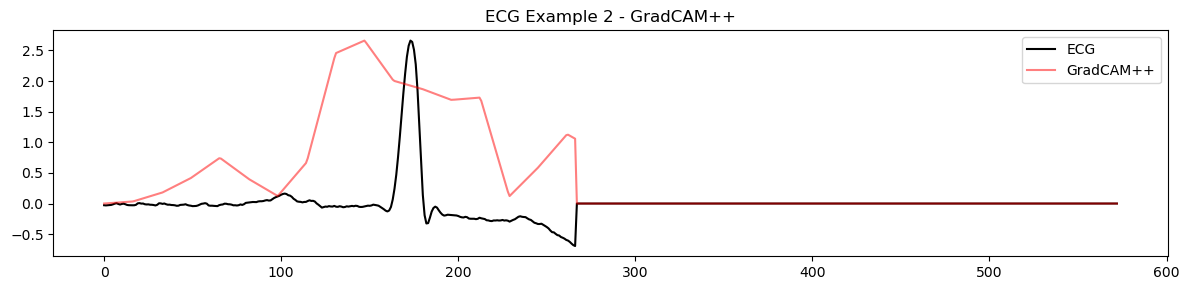

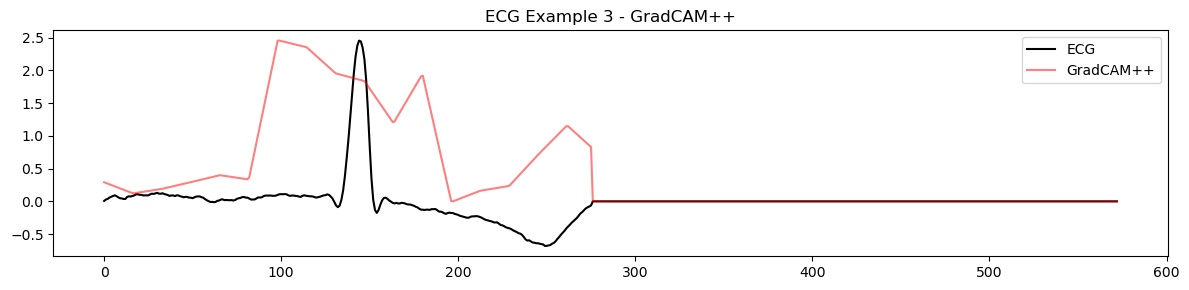

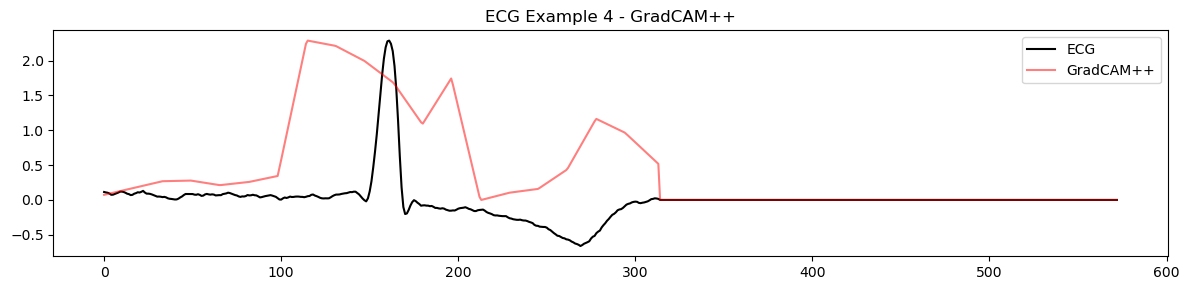

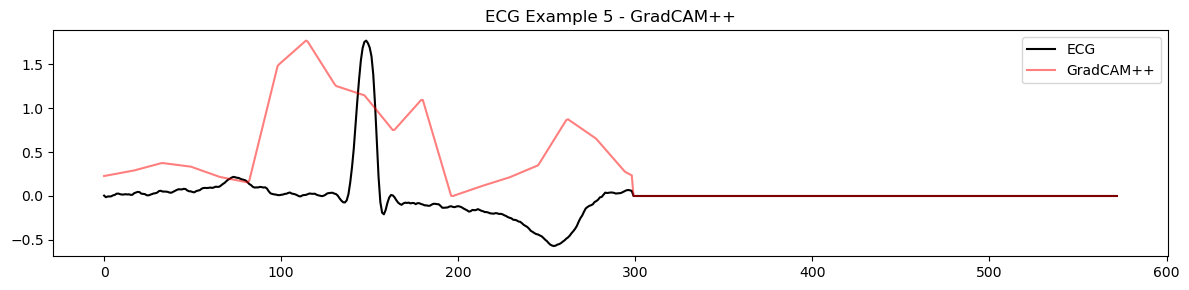

In [70]:
for i in range(len(samples)):
    plt.figure(figsize=(12, 3))
    plt.title(f"ECG Example {i+1} - GradCAM++")
    plt.plot(samples[i, :, 0], color='black', label='ECG')
    plt.plot(cam_plus_resized[i] / cam_plus_resized[i].max() * samples[i, :, 0].max(),  # scale heatmap to waveform
             color='red', alpha=0.5, label='GradCAM++')
    plt.legend()
    plt.tight_layout()
    plt.show()


## ScoreCAM

40/40 [==============================] - 0s 1ms/step


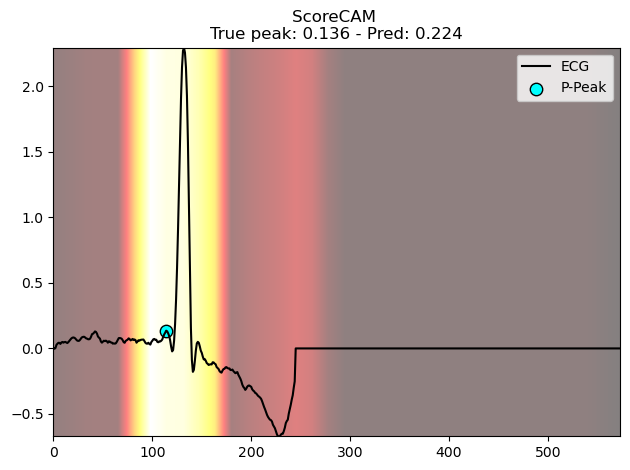

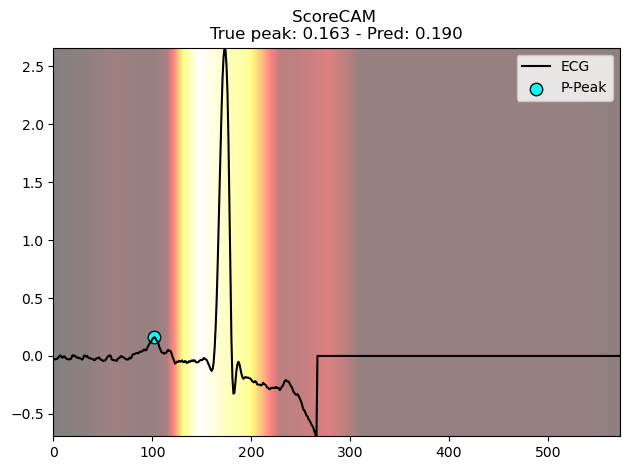

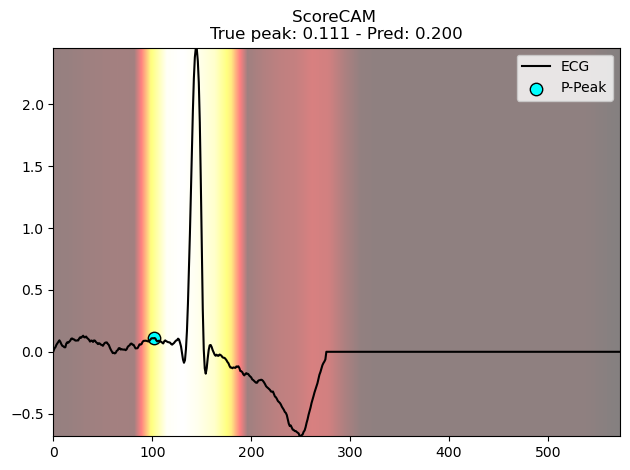

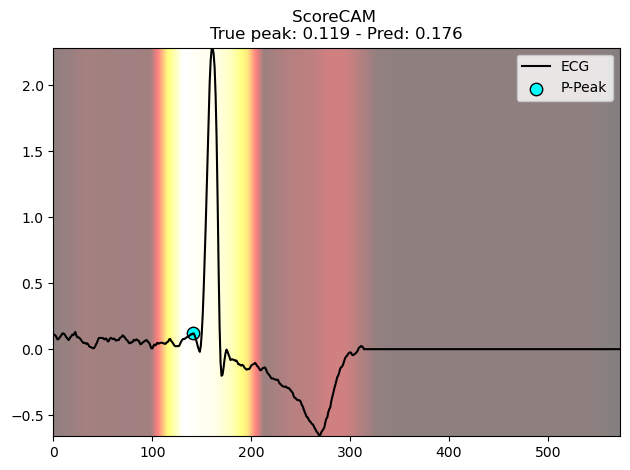

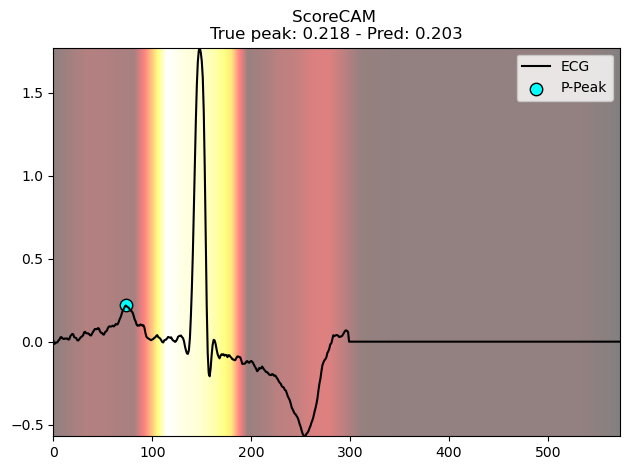

In [71]:
# Create ScoreCAM object
scorecam = Scorecam(model)

# Generate heatmap with ScoreCAM
cam = scorecam(score, samples, penultimate_layer= penultimate_layer)

cam_resized = np.array([
    scipy.ndimage.zoom(c, samples.shape[1] / c.shape[0], order=1)
    for c in cam
])

for i in range(len(samples)):
    plt.imshow(
        np.vstack([cam_resized[i], cam_resized[i]]), 
        cmap='hot', aspect='auto', alpha=0.5,
        extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
        origin='lower'
    )
    plt.plot(samples[i, :, 0], color='black', label='ECG')
    plt.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')

    plt.title(f"ScoreCAM \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Faster ScoreCAM

3/3 [==============================] - 0s 108ms/step


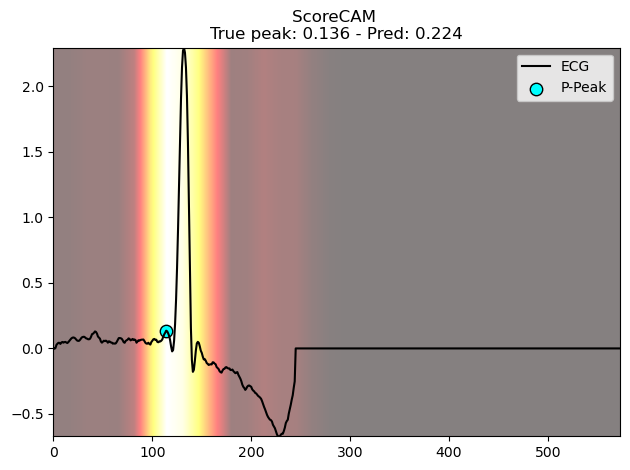

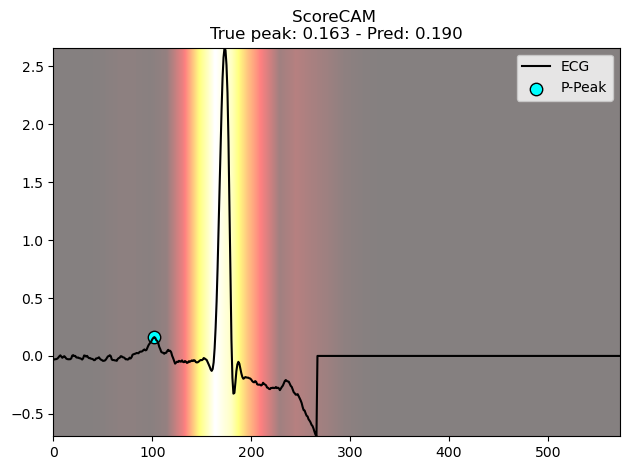

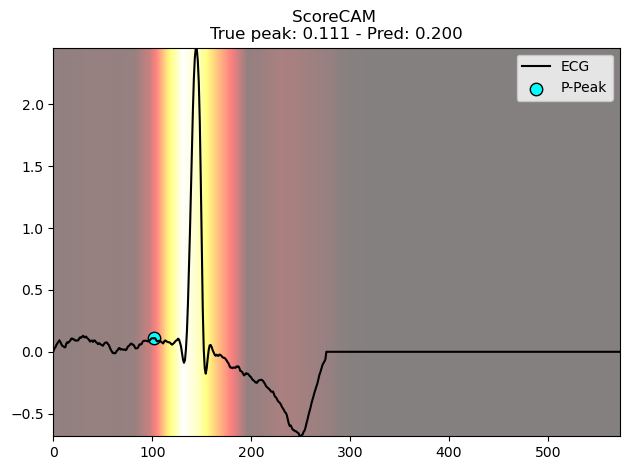

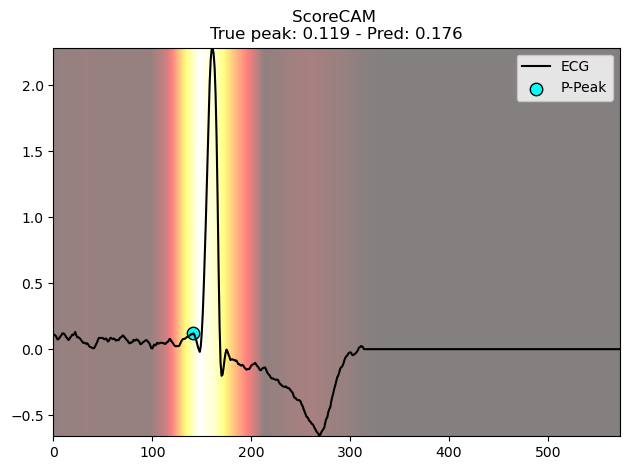

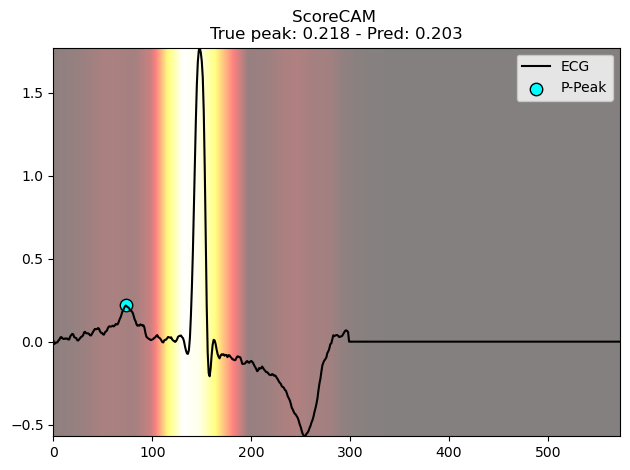

In [72]:
# Create ScoreCAM object
scorecam = Scorecam(model)

# Generate heatmap with ScoreCAM
cam = scorecam(score, samples, penultimate_layer= penultimate_layer,  max_N=10)

cam_resized = np.array([
    scipy.ndimage.zoom(c, samples.shape[1] / c.shape[0], order=1)
    for c in cam
])

for i in range(len(samples)):
    plt.imshow(
        np.vstack([cam_resized[i], cam_resized[i]]), 
        cmap='hot', aspect='auto', alpha=0.5,
        extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
        origin='lower'
    )
    plt.plot(samples[i, :, 0], color='black', label='ECG')
    plt.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')

    plt.title(f"ScoreCAM \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Guided BackPropagation

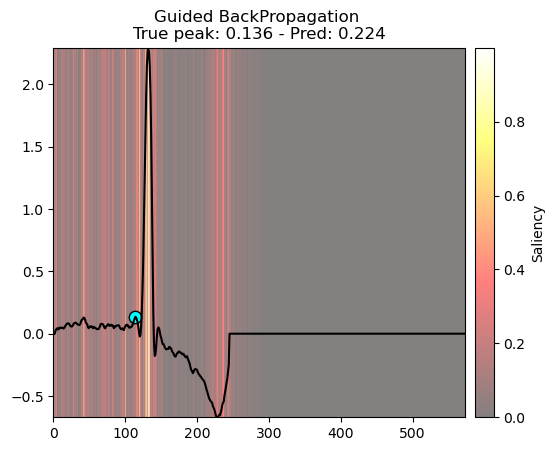

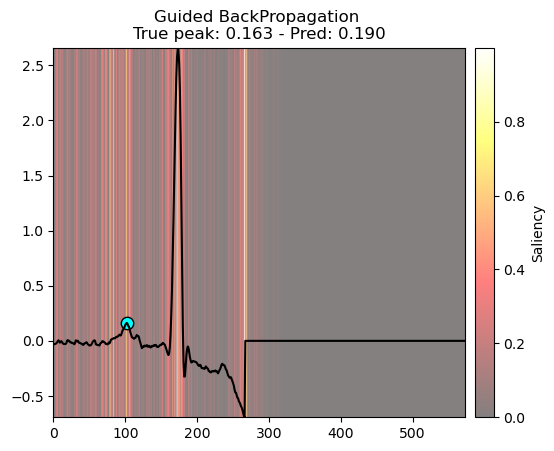

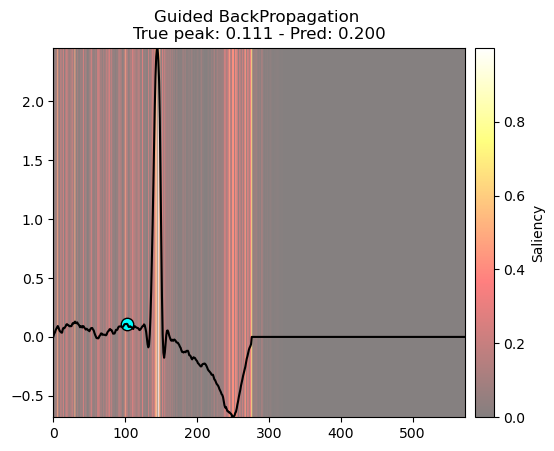

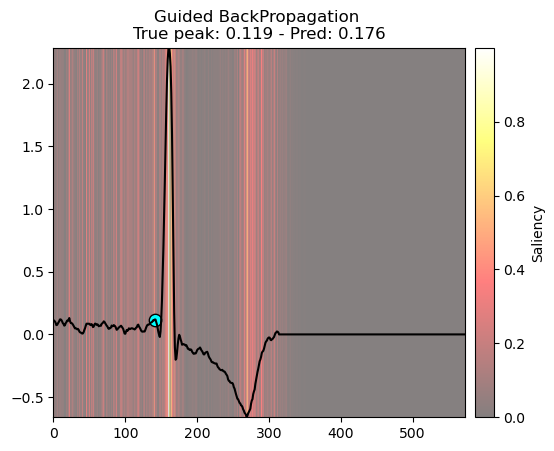

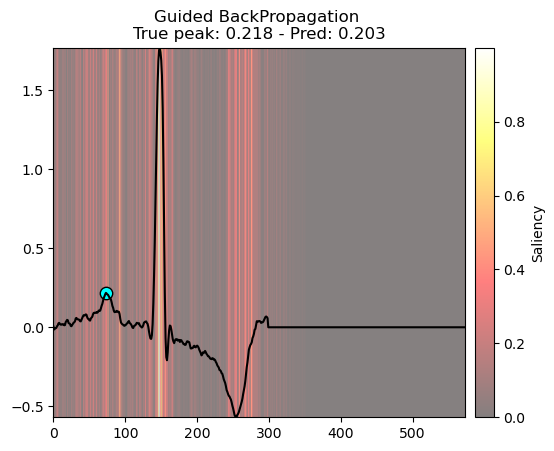

In [73]:
gb_saliency = Saliency(model, model_modifier=GuidedBackpropagation(), clone=True)
gb_saliency_map = gb_saliency(score, samples)

for i in range(len(samples)):
    im = plt.imshow(
    np.vstack([gb_saliency_map[i], gb_saliency_map[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
    origin='lower'
    )
    plt.plot(samples[i, :, 0], color='black', label='ECG')
    plt.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    plt.colorbar(im, label='Saliency', pad=0.02)
    plt.title(f"Guided BackPropagation \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
    plt.show()

## Guided GradCAM

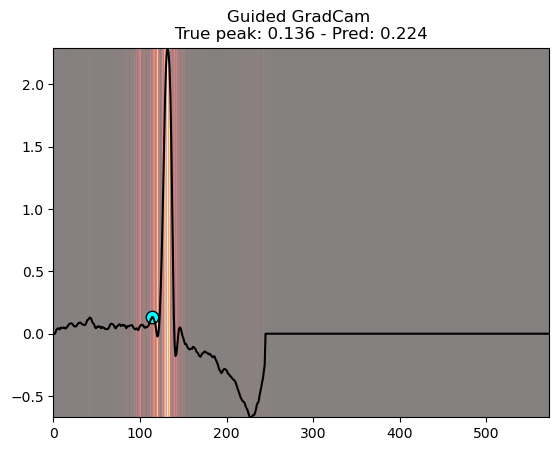

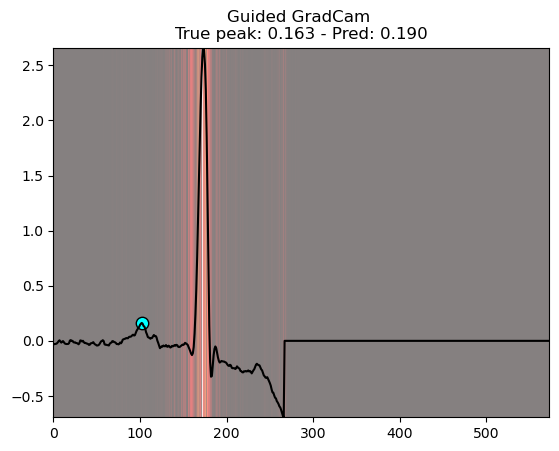

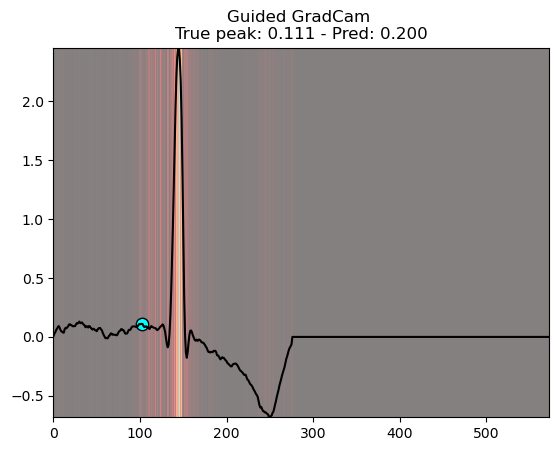

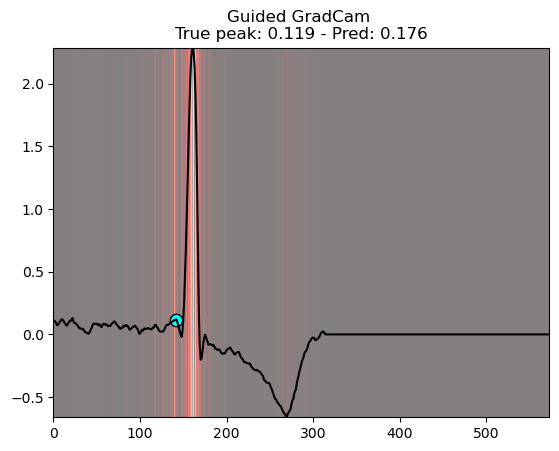

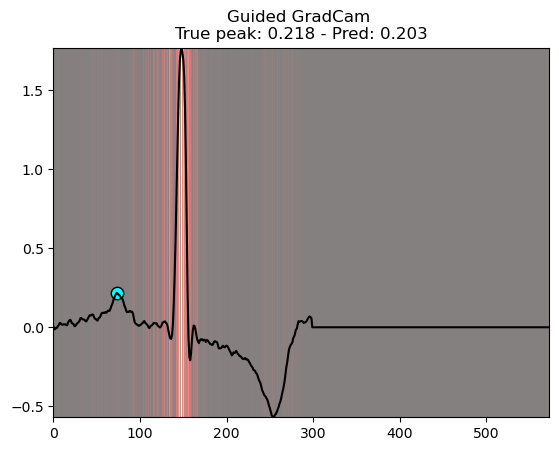

In [74]:
guided_gradcam = gb_saliency_map * cam_resized
for i in range(len(samples)):
    plt.imshow(
    np.vstack([guided_gradcam[i], guided_gradcam[i]]), 
    cmap='hot', aspect='auto', alpha=0.5,
    extent=[0, samples.shape[1], samples[i, :, 0].min(), samples[i, :, 0].max()],
    origin='lower'
    )
    plt.plot(samples[i, :, 0], color='black', label='ECG')
    plt.scatter( peaks[i] , samples[i][peaks[i]], c='cyan', edgecolors='k', s=80, label='P-Peak')
    
    plt.title(f"Guided GradCam \nTrue peak: {float(labels[i]):.3f} - Pred: {float(preds[i]):.3f}")
    
    plt.show()

# Activation Maximization

this section visualizes what different filters are highly activated by. Essentially what are the filters looking out for. This is done for the last conv layer and last dense layer as a test for now

## Last Conv Layer

200/200 [==============================] - 4s 18ms/step - Score: 3128.2944 - Norm: 486.5011


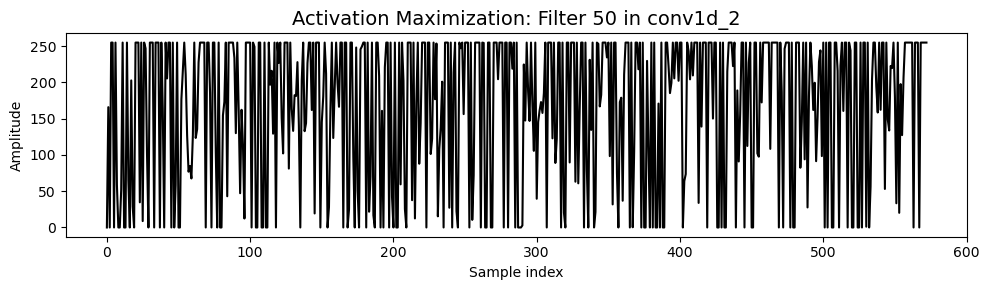

200/200 [==============================] - 4s 18ms/step - Score: 6436.5986 - Norm: 741.5301


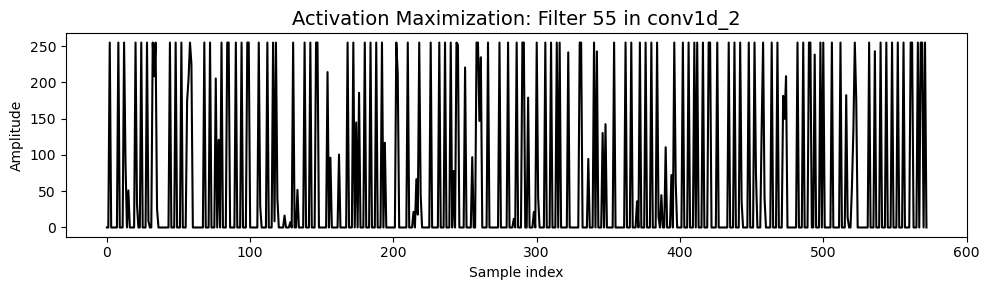

200/200 [==============================] - 4s 18ms/step - Score: 701.2355 - Norm: 254.8422


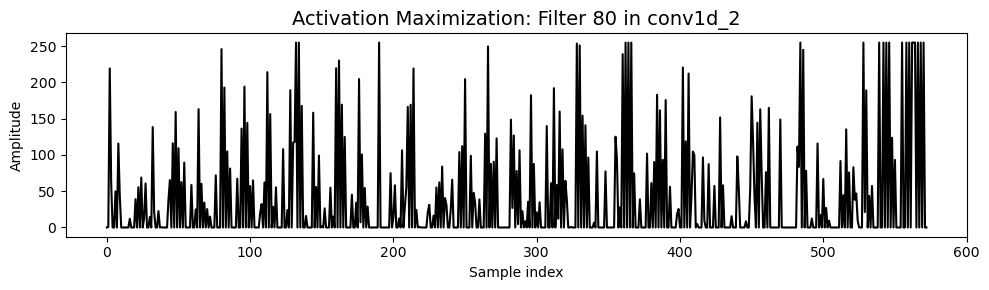

200/200 [==============================] - 4s 18ms/step - Score: 14578.7422 - Norm: 904.1940


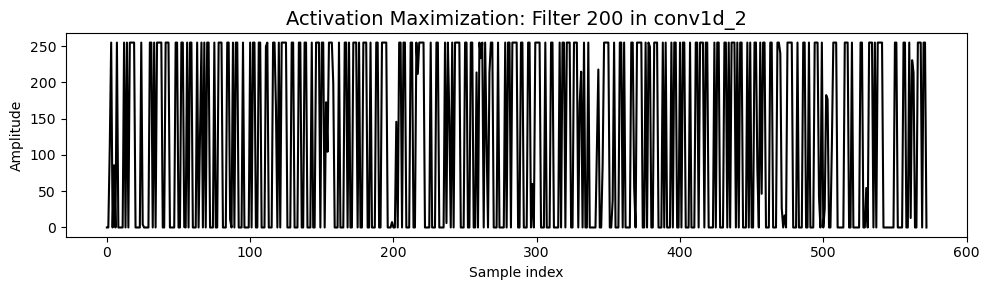

200/200 [==============================] - 4s 18ms/step - Score: 8.6680 - Norm: 44.1850


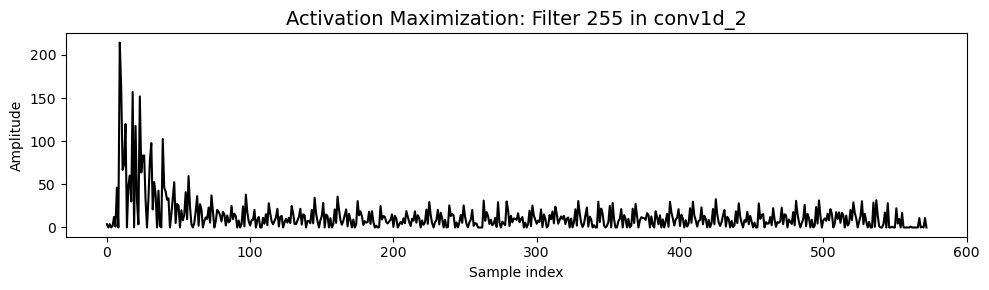

In [81]:
layer_name = 'conv1d_2' #target layer

#new model whose output is replaced to `block5_conv3` layer's output
extract_intermediate_layer = ExtractIntermediateLayer(index_or_name=layer_name)
#modify the model's last activation function to linear
replace2linear = ReplaceToLinear()

activation_maximization = ActivationMaximization(
    model,
    model_modifier=[extract_intermediate_layer, replace2linear],
    clone=False)

seq_len = samples.shape[1]
seed_input = np.random.normal(size=(1, seq_len, 1)).astype(np.float32)

filter_numbers = [50,55,80,200,255]
nrows = 1
ncols = len(filter_numbers)


for idx, i in enumerate(filter_numbers):
    def score_am(output):
        return tf.reduce_mean(output[:, :, i])

    # Generate maximized activation
    activations = activation_maximization(score_am, seed_input=seed_input, input_modifiers=[], regularizers=[Norm(2)], callbacks=[Progress()])
    activations = activations.numpy()

    plt.figure(figsize=(10, 3))
    plt.plot(activations[0].squeeze(), color='black')
    plt.title(f'Activation Maximization: Filter {i} in {layer_name}', fontsize=14)
    plt.xlabel("Sample index")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

## Last Dense Layer

200/200 [==============================] - 6s 27ms/step - Score: 18235.1680 - Norm: 804.2919


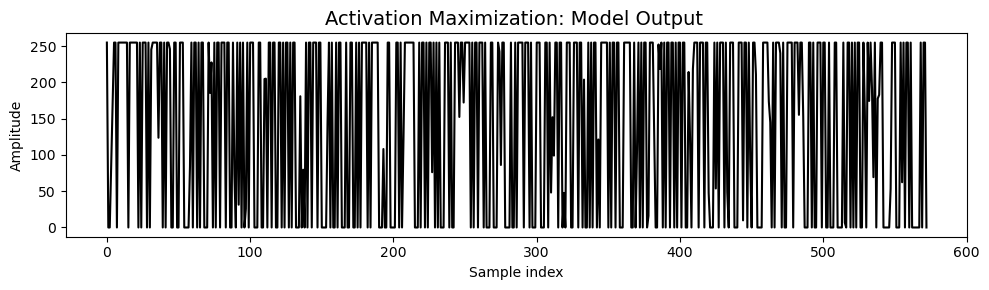

In [82]:
def score_dense(output):
    return output[:, 0]
    
activation_maximization = ActivationMaximization(model, model_modifier = None, clone=True)

seq_len = samples.shape[1]
seed_input = np.random.normal(size=(1, seq_len, 1)).astype(np.float32)

# Generate maximized activation
activations = activation_maximization(score_dense, seed_input=seed_input, input_modifiers=[], regularizers=[Norm(2)], callbacks=[Progress()])
activations = activations.numpy()

plt.figure(figsize=(10, 3))
plt.plot(activations[0].squeeze(), color='black')
plt.title(f'Activation Maximization: Model Output ', fontsize=14)
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()